# CAPA 0

In [7]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from dataclasses import dataclass, replace
from typing import Protocol, Literal, Union, Mapping, Optional, Dict, List, Tuple
import math
import numpy as np
import pandas as pd
import logging
import hashlib

# Configuración del sistema de logging para trazabilidad de la simulación
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("capa0_simulation.log"),
        logging.StreamHandler()
    ]
)

# Tipo auxiliar para manejar tanto valores escalares como series temporales
NumberOrSeries = Union[float, int, pd.Series]

# ---------------------------------------------------------------------
# Estructuras de datos para entrada/salida
# ---------------------------------------------------------------------

@dataclass
class PerfilSuelo:
    """
    Estructura del perfil de suelo multicapa (4 capas: 20, 40, 60, 90 cm).
    La estratificación permite capturar la heterogeneidad vertical de los
    procesos hídricos en el viñedo, diferenciando evaporación superficial,
    infiltración progresiva y extracción radicular por profundidad.
    """
    profundidades: List[str]          # Etiquetas de profundidad (cm) Ej: ['20','40','60','90'] 
    theta: Dict[str, NumberOrSeries]  # Contenido volumétrico de agua actual (m³/m³)
    FC: Dict[str, float]              # Capacidad de campo por capa (m³/m³)
    PWP: Dict[str, float]             # Punto de marchitez permanente por capa (m³/m³)
    pesos: Dict[str, float]           # Pesos de contribución radicular por capa
    
    def validar(self) -> bool:
        """Validación de consistencia física del perfil de suelo"""
        comunes = (set(self.theta.keys()) & set(self.FC.keys()) &
                   set(self.PWP.keys()) & set(self.pesos.keys()))
        if not comunes:
            raise ValueError("Las claves de profundidad no coinciden entre theta/FC/PWP/pesos.")
        
        # Validar coherencia física: FC debe estar siempre por encima de PWP
        for d in comunes:
            if self.FC[d] <= self.PWP[d]:
                raise ValueError(f"FC debe ser > PWP en capa {d}.")
        
        # Validar rango físico de theta [0,1] por capa
        for d in comunes:
            th = self.theta[d]
            if isinstance(th, pd.Series):
                if ((th < 0) | (th > 1)).any():
                    raise ValueError(f"theta fuera de [0,1] en capa {d}.")
            else:
                if not (0.0 <= float(th) <= 1.0):
                    raise ValueError(f"theta={th} fuera de [0,1] en capa {d}.")
        
        # Normalizar pesos si no suman exactamente 1.0
        total_pesos = sum(self.pesos[d] for d in comunes)
        if abs(total_pesos - 1.0) > 1e-2:
            for d in comunes:
                self.pesos[d] /= total_pesos
        
        # Verificar que todas las series temporales compartan el mismo índice
        indices = []
        for d in comunes:
            if isinstance(self.theta[d], pd.Series):
                indices.append(self.theta[d].index)
        if indices and not all(idx.equals(indices[0]) for idx in indices):
            raise ValueError("Todas las series de theta deben compartir el mismo índice temporal.")
        
        return True
    
    def copiar(self) -> PerfilSuelo:
        return PerfilSuelo(
            profundidades=self.profundidades.copy(),
            theta=self.theta.copy(),
            FC=self.FC.copy(),
            PWP=self.PWP.copy(),
            pesos=self.pesos.copy()
        )

@dataclass(frozen=True)
class PasoEntrada:
    """
    Datos de entrada para un paso de cálculo. Agrupa variables meteorológicas FAO-56,
    parámetros de cultivo/suelo, y estado del perfil. Frozen=True evita modificaciones
    accidentales y permite hasheo para caching.
    """
    # Variables meteorológicas FAO-56
    Tmin: NumberOrSeries  # Temperatura mínima diaria (°C)
    Tmax: NumberOrSeries  # Temperatura máxima diaria (°C)
    RHmin: NumberOrSeries  # Humedad relativa mínima (%)
    RHmax: NumberOrSeries  # Humedad relativa máxima (%)
    Uz: NumberOrSeries  # Velocidad del viento a altura z (m/s)
    z_viento: float  # Altura de medición del viento (m)
    z_terreno: float  # Altitud sobre el nivel del mar (m)
    lat_deg: float  # Latitud de la parcela (grados decimales)
    J: NumberOrSeries  # Día juliano del año [1-366]
    Rs: NumberOrSeries  # Radiación solar medida (MJ/m²/día)
    
    # Variables de cultivo y aportes hídricos
    h_m: NumberOrSeries  # Altura media del cultivo (m)
    fc: NumberOrSeries  # Fracción de cobertura vegetal [0-1]
    fw: NumberOrSeries  # Fracción de suelo mojado por riego/lluvia [0-1]
    lluvia: NumberOrSeries  # Precipitación bruta del día (mm)
    lluvia_esperada_0_24h: NumberOrSeries  # Previsión de lluvia 0-24h (mm)
    lluvia_esperada_24_48h: NumberOrSeries  # Previsión de lluvia 24-48h (mm)
    irrig: NumberOrSeries  # Riego neto aplicado (mm, eficiencia ya descontada)
    
    # Parámetros Kcb por fase fenológica
    kcb_init: NumberOrSeries  # Coeficiente basal cultivo fase inicial [0-1.5]
    kcb_mid: NumberOrSeries  # Coeficiente basal cultivo fase media [0-1.5]
    kcb_method: Literal["linear", "given"]  # Método de cálculo: interpolación lineal o valor fijo
    
    # Estado de la capa superficial evaporativa
    De: NumberOrSeries  # Agotamiento de agua evaporable en superficie (mm)
    TEW: NumberOrSeries  # Agua total evaporable en superficie (mm)
    REW: NumberOrSeries  # Agua fácilmente evaporable en superficie (mm)
    
    # Perfil de suelo unificado
    perfil_suelo: Optional[PerfilSuelo] = None

@dataclass(frozen=True)
class PasoSalida:
    """
    Resultados del cálculo de la Capa 0. Incluye indicadores principales para las
    capas superiores y variables de trazabilidad para diagnóstico y auditoría.
    """
    # Indicadores principales (consumidos por Capas 1 y 2)
    Ks: NumberOrSeries  # Coeficiente de estrés hídrico [0-1]
    J: NumberOrSeries  # Día juliano [1-366]
    pe_prevista_0_24h: NumberOrSeries  # Precipitación efectiva prevista 0-24h (mm)
    pe_prevista_24_48h: NumberOrSeries  # Precipitación efectiva prevista 24-48h (mm)
    Pe: NumberOrSeries  # Precipitación efectiva actual (mm)
    ETc: NumberOrSeries  # Evapotranspiración del cultivo (mm/día)
    RSWC: NumberOrSeries  # Contenido relativo de agua en el suelo [0-1]
    
    # Variables de trazabilidad y diagnóstico
    DND: Optional[NumberOrSeries] = None  # Demanda neta diaria ETc-Pe (mm/día)
    TAW: Optional[float] = None  # Agua total disponible en el perfil (mm)
    RAW: Optional[NumberOrSeries] = None  # Agua fácilmente utilizable (mm)
    Dr: Optional[NumberOrSeries] = None  # Déficit de agua en el perfil (mm)
    p: Optional[NumberOrSeries] = None  # Fracción de agotamiento permitido [0-1]
    Kcb: Optional[NumberOrSeries] = None  # Coeficiente basal de cultivo [0-1.5]
    Ke: Optional[NumberOrSeries] = None  # Coeficiente de evaporación del suelo [0-1.5]
    Kc: Optional[NumberOrSeries] = None  # Coeficiente de cultivo total [0-1.5]
    Kcmax: Optional[NumberOrSeries] = None  # Coeficiente de cultivo máximo tras mojado [0-1.5]
    Kr: Optional[NumberOrSeries] = None  # Coeficiente de reducción de evaporación [0-1]
    few: Optional[NumberOrSeries] = None  # Fracción de suelo húmedo expuesto [0-1]
    De_end: Optional[NumberOrSeries] = None  # Agotamiento superficial al final del día (mm)
    ETo: Optional[NumberOrSeries] = None  # Evapotranspiración de referencia (mm/día)
    
    # Notas de control de calidad
    qc_notes: Optional[List[str]] = None  # Registro de correcciones/warnings aplicados

@dataclass
class SimulationState:
    """Estado de la simulación para encadenamiento entre días"""
    perfil_suelo: PerfilSuelo  # Estado del perfil multicapa
    De: NumberOrSeries  # Agotamiento superficial actual (mm)
    day: int  # Contador de día de simulación
    
    def copiar(self) -> SimulationState:
        return SimulationState(
            perfil_suelo=self.perfil_suelo.copiar(),
            De=self.De,
            day=self.day
        )

# ---------------------------------------------------------------------
# Strategy Pattern para cálculo de ETc
# ---------------------------------------------------------------------

class ETcStrategy(Protocol):
    """Protocolo para estrategias de cálculo de ETc"""
    def __call__(self, x: PasoEntrada, ETo: NumberOrSeries, Ks: NumberOrSeries) -> Dict[str, NumberOrSeries]:
        ...

# ---------------------------------------------------------------------
# Funciones auxiliares
# ---------------------------------------------------------------------

def clip01(x: NumberOrSeries) -> NumberOrSeries:
    """Restringe valores al rango [0,1]"""
    if isinstance(x, pd.Series):
        return x.clip(0, 1)
    return max(0.0, min(1.0, float(x)))

def validar_rango(valor: NumberOrSeries, nombre: str, min_val: float, max_val: float):
    """Valida que un valor esté dentro de rangos físicamente plausibles"""
    if isinstance(valor, pd.Series):
        if (valor < min_val).any() or (valor > max_val).any():
            raise ValueError(f"{nombre} tiene valores fuera del rango [{min_val}, {max_val}]")
    else:
        if not min_val <= float(valor) <= max_val:
            raise ValueError(f"{nombre} = {valor} fuera del rango [{min_val}, {max_val}]")

def calc_Pe(lluvia: NumberOrSeries) -> NumberOrSeries:
    """
    Precipitación efectiva según aproximación USDA-SCS adaptada a clima mediterráneo.
    En estas condiciones, se descarta lluvia < 3 mm y solo una fracción del resto
    resulta utilizable por el cultivo. Pe = max(0, 0.75 * (P - 3))
    """
    if isinstance(lluvia, pd.Series):
        return lluvia.apply(lambda v: max(0.0, 0.75 * (float(v) - 3.0)))
    return max(0.0, 0.75 * (float(lluvia) - 3.0))

def calc_RSWC_weighted(theta_by_depth: Mapping[str, NumberOrSeries],
                       FC_by_depth: Mapping[str, float],
                       PWP_by_depth: Mapping[str, float],
                       weights: Mapping[str, float]) -> NumberOrSeries:
    """
    Contenido relativo de agua en el suelo (RSWC) mediante integración ponderada
    por pesos de contribución radicular. Captura la heterogeneidad vertical del
    estado hídrico mejor que enfoques monolíticos.
    """
    depths = [d for d in weights.keys() if d in theta_by_depth and d in FC_by_depth and d in PWP_by_depth]
    if not depths:
        raise ValueError("No hay capas comunes entre theta/FC/PWP/weights.")
    
    parts = []
    eff_weights = []
    for d in depths:
        FC_d = FC_by_depth[d]
        PWP_d = PWP_by_depth[d]
        denom = FC_d - PWP_d
        if denom <= 0:
            continue
        
        theta_d = theta_by_depth[d]
        if isinstance(theta_d, pd.Series):
            rswc_i = ((theta_d - PWP_d) / denom).clip(0, 1)
        else:
            val = (float(theta_d) - PWP_d) / denom
            rswc_i = max(0.0, min(1.0, val))
        
        parts.append(rswc_i)
        eff_weights.append(weights[d])
    
    wsum = sum(eff_weights)
    if wsum <= 0:
        raise ValueError("La suma de pesos efectivos es 0.")
    eff_weights = [w / wsum for w in eff_weights]
    
    # Alinear series si es necesario
    if any(isinstance(p, pd.Series) for p in parts):
        idx = None
        parts_aligned: List[pd.Series] = []
        for p in parts:
            if isinstance(p, pd.Series):
                idx = p.index if idx is None else idx
                parts_aligned.append(p)
            else:
                parts_aligned.append(pd.Series([p] * len(idx), index=idx))
        return sum(w * p for w, p in zip(eff_weights, parts_aligned))
    
    return float(sum(w * float(p) for w, p in zip(eff_weights, parts)))

# ---------------------------------------------------------------------
# Cálculo de espesores y parámetros del perfil
# ---------------------------------------------------------------------

def thickness_map_from_profundidades(profundidades: List[str]) -> Dict[str, float]:
    """
    Calcula espesor de cada capa a partir de profundidades acumuladas.
    Mantiene las etiquetas originales para evitar desajustes en diccionarios.
    """
    pares = sorted([(float(p), p) for p in profundidades], key=lambda t: t[0])
    tm: Dict[str, float] = {}
    prev = 0.0
    for depth_cm, label in pares:
        tm[label] = depth_cm - prev
        prev = depth_cm
    return tm

def calc_TAW(perfil_suelo: PerfilSuelo) -> float:
    """
    Agua Total Disponible en el perfil (mm). TAW = 10 * Σ[(FC_i - PWP_i) * espesor_i]
    El factor 10 convierte de (m³/m³ * cm) a mm.
    """
    tm = thickness_map_from_profundidades(perfil_suelo.profundidades)
    return sum((perfil_suelo.FC[d] - perfil_suelo.PWP[d]) * tm[d] * 10.0 for d in tm)

def calc_RAW(TAW: float, p: NumberOrSeries) -> NumberOrSeries:
    """
    Agua Fácilmente Utilizable (mm). RAW = p * TAW, donde p es el factor de
    agotamiento permitido antes de que se inicie estrés hídrico.
    """
    if isinstance(p, pd.Series):
        return p * TAW
    return p * TAW

def calc_Dr(perfil_suelo: PerfilSuelo) -> NumberOrSeries:
    """
    Déficit de agua en el perfil (mm). Dr = 10 * Σ[(FC_i - θ_i) * espesor_i]
    Refleja el agotamiento acumulado respecto a capacidad de campo.
    """
    tm = thickness_map_from_profundidades(perfil_suelo.profundidades)
    Dr: Optional[NumberOrSeries] = None
    for d in tm:
        term = (perfil_suelo.FC[d] - perfil_suelo.theta[d]) * tm[d] * 10.0
        if Dr is None:
            Dr = term
        else:
            # Manejar suma de escalares y series
            if isinstance(Dr, pd.Series) or isinstance(term, pd.Series):
                if not isinstance(Dr, pd.Series):
                    Dr = pd.Series([Dr] * len(term.index), index=term.index)
                if not isinstance(term, pd.Series):
                    term = pd.Series([term] * len(Dr.index), index=Dr.index)
            Dr = Dr + term
    return Dr if Dr is not None else 0.0

def calc_Ks(Dr: NumberOrSeries, TAW: float, RAW: NumberOrSeries) -> NumberOrSeries:
    """
    Coeficiente de estrés hídrico (adimensional). Ks=1 cuando Dr≤RAW (sin estrés),
    y disminuye linealmente hasta 0 cuando Dr→TAW. Solo afecta a la transpiración
    del cultivo (Kcb), no a la evaporación del suelo (Ke).
    """
    if isinstance(Dr, pd.Series):
        Ks = pd.Series(1.0, index=Dr.index)
        if isinstance(RAW, pd.Series):
            mask = Dr > RAW
            Ks[mask] = (TAW - Dr[mask]) / (TAW - RAW[mask])
        else:
            mask = Dr > RAW
            Ks[mask] = (TAW - Dr[mask]) / (TAW - RAW)
        return Ks.clip(0, 1)
    else:
        if Dr <= RAW:
            return 1.0
        return max(0.0, min(1.0, (TAW - Dr) / (TAW - RAW)))

def calc_p_adjusted(p_ref: float, ETo: NumberOrSeries) -> NumberOrSeries:
    """
    Factor de agotamiento ajustado dinámicamente por demanda evaporativa.
    p = p_ref + 0.04*(5 - ETo), limitado a [0.1, 0.8]. Con mayor ETo, el cultivo
    es más sensible al déficit (p disminuye), activando el riego antes.
    """
    if isinstance(ETo, pd.Series):
        p = p_ref + 0.04 * (5 - ETo)
        return p.clip(0.1, 0.8)
    p = p_ref + 0.04 * (5 - float(ETo))
    return max(0.1, min(0.8, p))

# ---------------------------------------------------------------------
# Cálculo de ETo según FAO-56 Penman-Monteith
# ---------------------------------------------------------------------

def esat_scalar(T: float) -> float:
    """Presión de vapor de saturación a temperatura T (kPa)"""
    return 0.6108 * math.exp(17.27 * T / (T + 237.3))

def esat_vectorized(T: pd.Series) -> pd.Series:
    return 0.6108 * np.exp(17.27 * T / (T + 237.3))

def es_daily_scalar(Tmin: float, Tmax: float) -> float:
    """Presión de vapor de saturación media diaria (kPa)"""
    return 0.5 * (esat_scalar(Tmin) + esat_scalar(Tmax))

def es_daily_vectorized(Tmin: pd.Series, Tmax: pd.Series) -> pd.Series:
    return 0.5 * (esat_vectorized(Tmin) + esat_vectorized(Tmax))

def ea_from_RH_scalar(Tmin: float, Tmax: float, RHmin: float, RHmax: float) -> float:
    """Presión real de vapor a partir de HR mínima y máxima (kPa)"""
    return 0.5 * (esat_scalar(Tmin) * (RHmax / 100.0) + esat_scalar(Tmax) * (RHmin / 100.0))

def ea_from_RH_vectorized(Tmin: pd.Series, Tmax: pd.Series,
                          RHmin: pd.Series, RHmax: pd.Series) -> pd.Series:
    return 0.5 * (esat_vectorized(Tmin) * (RHmax / 100.0) +
                  esat_vectorized(Tmax) * (RHmin / 100.0))

def delta_slope_scalar(Tmean: float) -> float:
    """Pendiente de la curva de presión de vapor (kPa/°C)"""
    es = esat_scalar(Tmean)
    return 4098.0 * es / ((Tmean + 237.3) ** 2)

def delta_slope_vectorized(Tmean: pd.Series) -> pd.Series:
    es = esat_vectorized(Tmean)
    return 4098.0 * es / ((Tmean + 237.3) ** 2)

def pressure_from_z_scalar(z: float) -> float:
    """Presión atmosférica en función de la altitud (kPa)"""
    return 101.3 * ((293.0 - 0.0065 * z) / 293.0) ** 5.26

def pressure_from_z_vectorized(z: float, size: int) -> pd.Series:
    return pd.Series([pressure_from_z_scalar(z)] * size)

def lambda_from_T_scalar(Tmean: float) -> float:
    """Calor latente de vaporización (MJ/kg)"""
    return 2.501 - 0.002361 * Tmean

def lambda_from_T_vectorized(Tmean: pd.Series) -> pd.Series:
    return 2.501 - 0.002361 * Tmean

def psychrometric_gamma_scalar(P: float, lam: float) -> float:
    """Constante psicrométrica (kPa/°C)"""
    return 0.00163 * (P / lam)

def psychrometric_gamma_vectorized(P: pd.Series, lam: pd.Series) -> pd.Series:
    return 0.00163 * (P / lam)

def Ra_MJm2day_scalar(lat_deg: float, J: int) -> float:
    """Radiación extraterrestre (MJ/m²/día)"""
    Gsc = 0.0820  # Constante solar (MJ·m⁻²·min⁻¹)
    phi = math.radians(lat_deg)  # Latitud en radianes
    dr = 1.0 + 0.033 * math.cos(2 * math.pi * J / 365.0)  # Distancia relativa Tierra-Sol
    delta = 0.409 * math.sin(2 * math.pi * J / 365.0 - 1.39)  # Declinación solar (rad)
    ws = math.acos(-math.tan(phi) * math.tan(delta))  # Ángulo de puesta del sol (rad)
    return (24 * 60 / math.pi) * Gsc * dr * (
        ws * math.sin(phi) * math.sin(delta) +
        math.cos(phi) * math.cos(delta) * math.sin(ws)
    )

def Ra_MJm2day_vectorized(lat_deg: float, J_series: pd.Series) -> pd.Series:
    return J_series.apply(lambda J: Ra_MJm2day_scalar(lat_deg, int(J)))

def Rso_clear_sky_scalar(Ra: float, z: float) -> float:
    """Radiación en cielo despejado (MJ/m²/día)"""
    return (0.75 + 2e-5 * z) * Ra

def Rso_clear_sky_vectorized(Ra: pd.Series, z: float) -> pd.Series:
    return (0.75 + 2e-5 * z) * Ra

def Rns_shortwave_scalar(Rs: float, albedo: float = 0.23) -> float:
    """Radiación neta de onda corta (MJ/m²/día). Albedo≈0.23 para cultivos"""
    return (1.0 - albedo) * Rs

def Rns_shortwave_vectorized(Rs: pd.Series, albedo: float = 0.23) -> pd.Series:
    return (1.0 - albedo) * Rs

def Rn_longwave_scalar(Tmin: float, Tmax: float, ea: float,
                       Rs: float, Rso: float) -> float:
    """Radiación neta de onda larga (MJ/m²/día)"""
    sigma = 4.903e-9  # Constante de Stefan-Boltzmann (MJ·K⁻⁴·m⁻²·día⁻¹)
    Tkmax, Tkmin = Tmax + 273.16, Tmin + 273.16  # Conversión a Kelvin
    termT = (Tkmax ** 4 + Tkmin ** 4) / 2.0  # Término de temperatura
    termCld = 1.35 * (min(Rs / Rso, 1.0) if Rso > 1e-6 else 0.0) - 0.35  # Factor de nubosidad
    return sigma * termT * (0.34 - 0.14 * math.sqrt(max(ea, 0.01))) * termCld

def Rn_longwave_vectorized(Tmin: pd.Series, Tmax: pd.Series, ea: pd.Series,
                           Rs: pd.Series, Rso: pd.Series) -> pd.Series:
    sigma = 4.903e-9
    Tkmax, Tkmin = Tmax + 273.16, Tmin + 273.16
    termT = (Tkmax ** 4 + Tkmin ** 4) / 2.0
    termCld = 1.35 * (Rs / Rso.clip(lower=1e-6)).clip(upper=1.0) - 0.35
    return sigma * termT * (0.34 - 0.14 * np.sqrt(ea.clip(lower=0.01))) * termCld

def Rn_net_scalar(Tmin: float, Tmax: float, ea: float,
                  Ra: float, z: float, Rs: float,
                  albedo: float = 0.23) -> float:
    """Radiación neta total (MJ/m²/día)"""
    if Rs is None:
        raise ValueError("Falta Rs para estimar la radiación neta.")
    Rso = Rso_clear_sky_scalar(Ra, z)  # Radiación en cielo despejado
    Rns = Rns_shortwave_scalar(Rs, albedo)  # Radiación neta de onda corta
    RnL = Rn_longwave_scalar(Tmin, Tmax, ea, Rs, Rso)  # Radiación neta de onda larga
    return Rns - RnL

def Rn_net_vectorized(Tmin: pd.Series, Tmax: pd.Series, ea: pd.Series,
                      Ra: pd.Series, z: float, Rs: pd.Series,
                      albedo: float = 0.23) -> pd.Series:
    if Rs is None:
        raise ValueError("Falta Rs para estimar la radiación neta.")
    Rso = Rso_clear_sky_vectorized(Ra, z)
    Rns = Rns_shortwave_vectorized(Rs, albedo)
    RnL = Rn_longwave_vectorized(Tmin, Tmax, ea, Rs, Rso)
    return Rns - RnL

def wind_to_2m_scalar(Uz: float, z: float) -> float:
    """Corrección de viento medido a altura z para altura estándar de 2 m"""
    return Uz * (4.87 / math.log(67.8 * z - 5.42))

def wind_to_2m_vectorized(Uz: pd.Series, z: float) -> pd.Series:
    return Uz * (4.87 / np.log(67.8 * z - 5.42))

def eto_fao56_scalar(Tmin: float, Tmax: float, RHmin: float,
                     RHmax: float, Uz: float, z_viento: float,
                     z_terreno: float, lat_deg: float, J: int,
                     Rs: float) -> float:
    """
    Evapotranspiración de referencia según método FAO-56 Penman-Monteith (mm/día).
    Implementa íntegramente la ecuación (3) del marco teórico.
    """
    Tmean = 0.5 * (Tmin + Tmax)  # Temperatura media diaria (°C)
    es = es_daily_scalar(Tmin, Tmax)  # Presión de vapor de saturación (kPa)
    ea = min(ea_from_RH_scalar(Tmin, Tmax, RHmin, RHmax), es)  # Presión real de vapor (kPa)
    Delta = delta_slope_scalar(Tmean)  # Pendiente de la curva de presión de vapor (kPa/°C)
    lam = lambda_from_T_scalar(Tmean)  # Calor latente de vaporización (MJ/kg)
    P = pressure_from_z_scalar(z_terreno)  # Presión atmosférica (kPa)
    gamma = psychrometric_gamma_scalar(P, lam)  # Constante psicrométrica (kPa/°C)
    U2 = wind_to_2m_scalar(Uz, z_viento)  # Velocidad del viento a 2m (m/s)
    Ra = Ra_MJm2day_scalar(lat_deg, J)  # Radiación extraterrestre (MJ/m²/día)
    Rn = Rn_net_scalar(Tmin, Tmax, ea, Ra, z_terreno, Rs=Rs)  # Radiación neta (MJ/m²/día)
    G = 0.0  # Flujo de calor del suelo ≈0 a escala diaria
    
    # Ecuación FAO-56 Penman-Monteith
    numerator = (0.408 * Delta * (Rn - G) +
                 gamma * (900.0 / (Tmean + 273.0)) * U2 * (es - ea))
    denominator = Delta + gamma * (1.0 + 0.34 * U2)
    return numerator / denominator

def eto_fao56_vectorized(Tmin: pd.Series, Tmax: pd.Series, RHmin: pd.Series,
                         RHmax: pd.Series, Uz: pd.Series, z_viento: float,
                         z_terreno: float, lat_deg: float, J_series: pd.Series,
                         Rs: pd.Series) -> pd.Series:
    """Versión vectorizada de ETo para series temporales"""
    Tmean = 0.5 * (Tmin + Tmax)
    es = es_daily_vectorized(Tmin, Tmax)
    ea = np.minimum(ea_from_RH_vectorized(Tmin, Tmax, RHmin, RHmax), es)
    Delta = delta_slope_vectorized(Tmean)
    lam = lambda_from_T_vectorized(Tmean)
    size = len(Tmin)
    P = pressure_from_z_vectorized(z_terreno, size)
    gamma = psychrometric_gamma_vectorized(P, lam)
    U2 = wind_to_2m_vectorized(Uz, z_viento)
    Ra = Ra_MJm2day_vectorized(lat_deg, J_series)
    Rn = Rn_net_vectorized(Tmin, Tmax, ea, Ra, z_terreno, Rs=Rs)
    G = pd.Series(0.0, index=Tmin.index)
    
    numerator = (0.408 * Delta * (Rn - G) +
                 gamma * (900.0 / (Tmean + 273.0)) * U2 * (es - ea))
    denominator = Delta + gamma * (1.0 + 0.34 * U2)
    return numerator / denominator

# ---------------------------------------------------------------------
# Enfoque Dual Kc (FAO-56)
# ---------------------------------------------------------------------

def kc_max(U2: float, Rhmin: float, h_m: float, Kcb: float) -> float:
    """
    Coeficiente de cultivo máximo tras evento de mojado. Ajusta por viento, humedad
    y altura del dosel. Limitado entre 1.05 y 1.3, y nunca menor que Kcb + 0.05
    para mantener coherencia física.
    """
    base = 1.2 + (0.04 * (U2 - 2.0) - 0.004 * (Rhmin - 45.0)) * (h_m / 3.0) ** 0.3
    return max(1.05, min(1.3, max(base, Kcb + 0.05)))

def kc_max_vectorized(U2: pd.Series, Rhmin: pd.Series, h_m: pd.Series, Kcb: pd.Series) -> pd.Series:
    base = 1.2 + (0.04 * (U2 - 2.0) - 0.004 * (Rhmin - 45.0)) * (h_m / 3.0) ** 0.3
    return np.maximum(1.05, np.minimum(1.3, np.maximum(base, Kcb + 0.05)))

def few_from_fc_fw(fc: float, fw: float) -> float:
    """
    Fracción de suelo húmedo expuesto. few = min(1-fc, fw), donde fc es fracción
    cubierta por vegetación y fw es fracción mojada por riego/lluvia. Determina
    la superficie disponible para evaporación directa.
    """
    fc = max(0.0, min(1.0, fc))
    fw = max(0.0, min(1.0, fw))
    return max(0.0, min(1.0 - fc, fw))

def few_from_fc_fw_vectorized(fc: pd.Series, fw: pd.Series) -> pd.Series:
    fc = fc.clip(0, 1)
    fw = fw.clip(0, 1)
    return np.maximum(0.0, np.minimum(1.0 - fc, fw))

def kr_from_de(De: float, TEW: float, REW: float) -> float:
    """
    Coeficiente de reducción de evaporación del suelo. Kr=1 cuando De≤REW
    (fase 1: evaporación limitada por energía), y disminuye linealmente cuando
    De>REW (fase 2: evaporación limitada por disponibilidad de agua superficial).
    """
    if De <= REW:
        return 1.0
    if TEW <= REW:
        return 0.0
    return max(0.0, min(1.0, (TEW - De) / (TEW - REW)))

def kr_from_de_vectorized(De: pd.Series, TEW: pd.Series, REW: pd.Series) -> pd.Series:
    kr = pd.Series(1.0, index=De.index)
    mask = De > REW
    kr[mask] = (TEW[mask] - De[mask]) / (TEW[mask] - REW[mask])
    kr[kr < 0] = 0.0
    return kr

def kcb_linear_from_fc(fc: float, kcb_init: float, kcb_mid: float) -> float:
    """
    Interpolación lineal de Kcb según fracción de cobertura. Permite transición
    suave entre fase inicial (kcb_init) y desarrollo pleno (kcb_mid) del cultivo.
    """
    fc = max(0.0, min(1.0, fc))
    return kcb_init + (kcb_mid - kcb_init) * fc

def kcb_linear_from_fc_vectorized(fc: pd.Series, kcb_init: pd.Series, kcb_mid: pd.Series) -> pd.Series:
    fc = fc.clip(0, 1)
    return kcb_init + (kcb_mid - kcb_init) * fc

def kcb_adjust_climate_height(Kcb: float, U2: float, Rhmin: float, h_m: float) -> float:
    """
    Ajuste climático de Kcb según FAO-56. Corrige por condiciones locales de viento,
    humedad mínima y altura del cultivo. Esencial para adaptar valores tabulados a
    condiciones específicas de parcela.
    """
    adjustment = (0.04 * (U2 - 2.0) - 0.004 * (Rhmin - 45.0)) * (h_m / 3.0) ** 0.3
    return max(0.1, min(1.3, Kcb + adjustment))

def kcb_adjust_climate_height_vectorized(Kcb: pd.Series, U2: pd.Series, 
                                        Rhmin: pd.Series, h_m: pd.Series) -> pd.Series:
    adjustment = (0.04 * (U2 - 2.0) - 0.004 * (Rhmin - 45.0)) * (h_m / 3.0) ** 0.3
    return np.maximum(0.1, np.minimum(1.3, Kcb + adjustment))

class DualKcStrategy:
    """
    Implementación del enfoque dual Kc = Kcb·Ks + Ke (FAO-56, ecuación 11).
    Separa el componente basal de transpiración (Kcb) del componente de evaporación
    superficial (Ke), permitiendo que solo Kcb se vea afectado por estrés hídrico (Ks).
    """
    def __call__(self, x: PasoEntrada, ETo: NumberOrSeries, Ks: NumberOrSeries) -> Dict[str, NumberOrSeries]:
        is_series = isinstance(ETo, pd.Series)
        
        def to_series(v, default_idx=None):
            if isinstance(v, pd.Series):
                return v
            elif is_series and default_idx is not None:
                return pd.Series([v] * len(default_idx), index=default_idx)
            return v
        
        if is_series:
            idx = ETo.index
            Tmin = to_series(x.Tmin, idx)
            Tmax = to_series(x.Tmax, idx)
            Rhmin = to_series(x.RHmin, idx)
            Uz = to_series(x.Uz, idx)
            h_m = to_series(x.h_m, idx)
            fc = to_series(x.fc, idx)
            fw = to_series(x.fw, idx)
            lluvia = to_series(x.lluvia, idx)
            irrig = to_series(x.irrig, idx)
            kcb_init = to_series(x.kcb_init, idx)
            kcb_mid = to_series(x.kcb_mid, idx)
            De = to_series(x.De, idx)
            TEW = to_series(x.TEW, idx)
            REW = to_series(x.REW, idx)
            
            U2 = wind_to_2m_vectorized(Uz, x.z_viento)
            
            # Kcb: interpolación lineal o valor dado, seguido de ajuste climático
            Kcb_base = kcb_linear_from_fc_vectorized(fc, kcb_init, kcb_mid) if x.kcb_method == "linear" else kcb_mid
            Kcb = kcb_adjust_climate_height_vectorized(Kcb_base, U2, Rhmin, h_m)
            Kcmax = kc_max_vectorized(U2, Rhmin, h_m, Kcb)
            
            # Actualizar De con aportes del día antes de calcular Kr
            added = lluvia + irrig
            De_i = np.maximum(0.0, De - added)
            De_i = np.minimum(De_i, TEW)
            Kr = kr_from_de_vectorized(De_i, TEW, REW)
            
            # Ke: evaporación del suelo limitada por fracción expuesta y Kr
            few = few_from_fc_fw_vectorized(fc, fw)
            Ke_star = Kr * (Kcmax - Kcb)
            Ke_limit = few * Kcmax
            Ke = np.maximum(0.0, np.minimum(Ke_star, Ke_limit))
            
            # Kc total: solo Kcb se ve afectado por Ks (estrés hídrico)
            if Ks is not None:
                Kc = (Kcb * Ks) + Ke
            else:
                Kc = Kcb + Ke
            
            ETc = Kc * ETo
            Es = Ke * ETo
            De_end = np.minimum(TEW, De_i + Es)
            
            return {
                'ETc': ETc, 'Kcb': Kcb, 'Ke': Ke, 'Kc': Kc,
                'Kcmax': Kcmax, 'Kr': Kr, 'few': few, 'De_end': De_end, 'ETo': ETo
            }
        
        # Versión escalar
        U2 = wind_to_2m_scalar(float(x.Uz), x.z_viento)
        RHmin_val = float(x.RHmin)
        h_val = float(x.h_m)
        fc_val = float(x.fc)
        fw_val = float(x.fw)
        lluvia_val = float(x.lluvia)
        irrig_val = float(x.irrig)
        kcb_init_val = float(x.kcb_init)
        kcb_mid_val = float(x.kcb_mid)
        De_val = float(x.De)
        TEW_val = float(x.TEW)
        REW_val = float(x.REW)
        
        Kcb_base = kcb_linear_from_fc(fc_val, kcb_init_val, kcb_mid_val) if x.kcb_method == "linear" else kcb_mid_val
        Kcb = kcb_adjust_climate_height(Kcb_base, U2, RHmin_val, h_val)
        Kcmax = kc_max(U2, RHmin_val, h_val, Kcb)
        
        added = max(0.0, lluvia_val) + max(0.0, irrig_val)
        De_i = max(0.0, De_val - added)
        De_i = min(TEW_val, De_i)
        Kr = kr_from_de(De_i, TEW_val, REW_val)
        
        few = few_from_fc_fw(fc_val, fw_val)
        Ke_star = Kr * (Kcmax - Kcb)
        Ke_limit = few * Kcmax
        Ke = max(0.0, min(Ke_star, Ke_limit))
        
        Kc = (Kcb * float(Ks)) + Ke if Ks is not None else (Kcb + Ke)
        ETo_val = float(ETo)
        ETc = Kc * ETo_val
        Es = Ke * ETo_val
        De_end = min(TEW_val, De_i + Es)
        
        return {
            'ETc': ETc, 'Kcb': Kcb, 'Ke': Ke, 'Kc': Kc,
            'Kcmax': Kcmax, 'Kr': Kr, 'few': few, 'De_end': De_end, 'ETo': ETo_val
        }

# ---------------------------------------------------------------------
# Balance hídrico multicapa con conservación de masa
# ---------------------------------------------------------------------

def actualizar_balance_hidrico(perfil_suelo: PerfilSuelo, 
                               ETo: NumberOrSeries,
                               Ke: NumberOrSeries,
                               Kcb: NumberOrSeries,
                               Ks: NumberOrSeries,
                               Pe: NumberOrSeries,
                               irrig: NumberOrSeries,
                               lluvia: NumberOrSeries,
                               De_prev: NumberOrSeries,
                               TEW: NumberOrSeries,
                               check_masa: bool = True,
                               logger: Optional[logging.Logger] = None) -> PerfilSuelo:
    """
    Actualiza contenido de agua (θ) por capa mediante algoritmo de dos pasadas:
    
    1ª PASADA: Procesa capas secuencialmente aplicando:
       - Evaporación (E): solo en capa superficial (0-30 cm)
       - Transpiración (T): distribuida por pesos radiculares
       - Entradas: Pe + irrig (percolan), Psurf (humedece superficie)
       - Psurf representa humedecimiento superficial por lluvias pequeñas
    
    2ª PASADA: Redistribuye déficit de T no satisfecho entre capas con agua
    disponible, simulando capacidad adaptativa del sistema radicular.
    
    NOTA: 'irrig' debe venir como riego neto (eficiencia ya aplicada).
    """
    # Convertir todas las entradas a float (día único)
    E = float(Ke) * float(ETo)
    T_total = float(Kcb) * float(Ks) * float(ETo)
    Pe_val = float(Pe)
    irrig_neto = float(irrig)
    lluvia_val = float(lluvia)
    De_prev_val = float(De_prev)
    TEW_val = float(TEW)
    
    # Psurf: humedecimiento superficial incluso con lluvias pequeñas que no generan Pe
    psurf = max(0.0, min(lluvia_val + irrig_neto, max(0.0, TEW_val - De_prev_val)))
    
    perfil_actualizado = perfil_suelo.copiar()
    tm = thickness_map_from_profundidades(perfil_actualizado.profundidades)
    etiquetas = list(tm.keys())
    espesores = [tm[d] for d in etiquetas]
    
    # Almacenamiento inicial para verificación de cierre de masa
    almacen_ini = sum(float(perfil_actualizado.theta[d]) * tm[d] * 10.0 for d in etiquetas)
    
    # Distribución de transpiración según pesos radiculares
    T_por_capa = {d: T_total * perfil_actualizado.pesos[d] for d in etiquetas}
    
    # Entradas que percolan al perfil (Pe + riego)
    percolacion = Pe_val + irrig_neto
    
    # PRIMERA PASADA: extracción y percolación descendente
    deficit_transpiracion = 0.0
    extr_T_aplicada: Dict[str, float] = {d: 0.0 for d in etiquetas}
    
    for i, d in enumerate(etiquetas):
        esp = espesores[i]
        FC = perfil_actualizado.FC[d]
        PWP = perfil_actualizado.PWP[d]
        
        # Agua disponible tras entradas (mm)
        theta_prev = float(perfil_actualizado.theta[d])
        agua_mm = theta_prev * esp * 10.0 + percolacion + (psurf if i == 0 else 0.0)
        
        # Capacidad de extracción (no bajar de PWP)
        cap_mm = max(0.0, agua_mm - PWP * esp * 10.0)
        
        # Evaporación: solo en capa superficial
        extr_E = min(E, cap_mm) if i == 0 else 0.0
        cap_mm -= extr_E
        
        # Transpiración limitada por disponibilidad
        extr_T = min(T_por_capa[d], cap_mm)
        extr_T_aplicada[d] = extr_T
        
        # Aplicar extracciones
        agua_mm = max(0.0, agua_mm - extr_E - extr_T)
        
        # Acumular déficit no extraído
        deficit_transpiracion += float(T_por_capa[d] - extr_T)
        
        # Nuevo θ provisional
        nuevo_theta = agua_mm / (esp * 10.0)
        
        # Percolación hacia capa inferior si excede FC
        if nuevo_theta > FC:
            percolacion = (nuevo_theta - FC) * esp * 10.0
            nuevo_theta = FC
        else:
            percolacion = 0.0
        
        # Límite inferior en PWP
        if nuevo_theta < PWP:
            nuevo_theta = PWP
        
        perfil_actualizado.theta[d] = nuevo_theta
    
    # SEGUNDA PASADA: redistribución de déficit de transpiración
    if deficit_transpiracion > 1e-6:
        disponible: Dict[str, float] = {}
        for i, d in enumerate(etiquetas):
            esp = espesores[i]
            agua_mm = float(perfil_actualizado.theta[d]) * esp * 10.0
            disp = max(0.0, agua_mm - perfil_actualizado.PWP[d] * esp * 10.0)
            disponible[d] = disp
        
        total_disp = sum(disponible.values())
        if total_disp > 0.0:
            for i, d in enumerate(etiquetas):
                esp = espesores[i]
                cuota = deficit_transpiracion * (disponible[d] / total_disp)
                agua_mm = float(perfil_actualizado.theta[d]) * esp * 10.0
                extrae = min(cuota, max(0.0, agua_mm - perfil_actualizado.PWP[d] * esp * 10.0))
                perfil_actualizado.theta[d] = (agua_mm - extrae) / (esp * 10.0)
    
    # Verificación de cierre de masa (control de calidad numérica)
    if check_masa:
        almacen_fin = sum(float(perfil_actualizado.theta[d]) * tm[d] * 10.0 for d in etiquetas)
        delta = almacen_fin - almacen_ini
        entradas = Pe_val + irrig_neto + psurf
        salidas = E + sum(extr_T_aplicada.values())
        residuo = entradas - salidas - delta
        if abs(residuo) > 1.0:  # Tolerancia: 1 mm
            (logger or logging.getLogger(__name__)).warning(
                f"[Cierre de masa] Residuo={residuo:.2f} mm "
                f"(Entradas={entradas:.2f}, Salidas={salidas:.2f}, ΔAlm={delta:.2f})"
            )
    
    return perfil_actualizado

# ---------------------------------------------------------------------
# Orquestador principal - Capa 0
# ---------------------------------------------------------------------

class PreprocessCapa0:
    """
    Capa 0: Cálculo de indicadores biofísicos fundamentales.
    
    Implementa ETo (FAO-56 Penman-Monteith), RSWC multicapa, ETc (Dual Kc),
    Pe (precipitación efectiva) y señales de estado hídrico del perfil.
    
    Diseño: Cálculo puro sin efectos laterales. La actualización de estado se
    delega a simular_multiples_dias() para mantener separación de responsabilidades.
    """
    
    _instance_count = 0
    
    def __init__(self, p_ref: float = 0.4,
                 etc_strategy: Optional[ETcStrategy] = None,
                 enable_cache: bool = True, log_level: int = logging.INFO,
                 auto_fill_nan: bool = True):
        """
        Parámetros:
            p_ref: factor de agotamiento de referencia (0.4 según FAO-56 para vid)
            etc_strategy: estrategia de cálculo de ETc (por defecto DualKc)
            enable_cache: habilitar cache MD5 para ETo escalar
            auto_fill_nan: rellenar automáticamente datos faltantes
        """
        PreprocessCapa0._instance_count += 1
        self.p_ref = p_ref
        self.etc = etc_strategy or DualKcStrategy()
        self.enable_cache = enable_cache
        self.auto_fill_nan = auto_fill_nan
        self.cache: Dict[str, NumberOrSeries] = {}
        self.logger = logging.getLogger(f"PreprocessCapa0_{self._instance_count}")
        self.logger.setLevel(log_level)
        
        self._last_qc_notes: List[str] = []
    
    def __validar_inputs(self, x: PasoEntrada) -> None:
        """
        Validación exhaustiva de entradas: rangos físicos, coherencia y completitud.
        Primer nivel de defensa para garantizar calidad de datos en capas superiores.
        """
        if x.kcb_method not in ["linear", "given"]:
            raise ValueError("kcb_method debe ser 'linear' o 'given'.")
        if x.perfil_suelo is None:
            raise ValueError("Se requiere perfil_suelo.")
        x.perfil_suelo.validar()
        
        # Validación de rangos físicamente plausibles (ver documentación capítulo 4.2)
        validar_rango(x.Tmin, "Tmin", -30, 40)
        validar_rango(x.Tmax, "Tmax", -10, 55)
        validar_rango(x.RHmin, "RHmin", 0, 100)
        validar_rango(x.RHmax, "RHmax", 0, 100)
        validar_rango(x.Uz, "Uz", 0, 50)
        validar_rango(x.J, "J", 1, 366)
        validar_rango(x.Rs, "Rs", 0, 50)
        validar_rango(x.h_m, "h_m", 0, 3)
        validar_rango(x.fc, "fc", 0, 1)
        validar_rango(x.fw, "fw", 0, 1)
        validar_rango(x.lluvia, "lluvia", 0, 100)
        validar_rango(x.lluvia_esperada_0_24h, "lluvia_esperada_0_24h", 0, 100)
        validar_rango(x.lluvia_esperada_24_48h, "lluvia_esperada_24_48h", 0, 100)
        validar_rango(x.irrig, "irrig", 0, 100)
        validar_rango(x.kcb_init, "kcb_init", 0, 1.5)
        validar_rango(x.kcb_mid, "kcb_mid", 0, 1.5)
        validar_rango(x.De, "De", 0, 100)
        validar_rango(x.TEW, "TEW", 0, 100)
        validar_rango(x.REW, "REW", 0, 100)
        
        self._last_qc_notes = []
        
        # Tratamiento de datos faltantes (series temporales)
        if isinstance(x.Tmin, pd.Series):
            for field in ['Tmin', 'Tmax', 'RHmin', 'RHmax', 'Uz']:
                series = getattr(x, field)
                if series.isna().any():
                    if self.auto_fill_nan:
                        if field in ['Tmin', 'Tmax']:
                            filled = series.interpolate()
                            self._last_qc_notes.append(f"{field}: interpolado")
                        else:
                            filled = series.ffill().bfill()
                            self._last_qc_notes.append(f"{field}: ffill/bfill")
                        object.__setattr__(x, field, filled)
                        self.logger.info(f"Relleno de NaN aplicado en {field}.")
            
            # Tratamiento especial para Rs (puede tener gaps)
            if isinstance(x.Rs, pd.Series) and x.Rs.isna().any() and self.auto_fill_nan:
                filled = x.Rs.interpolate(limit_direction='both')
                object.__setattr__(x, 'Rs', filled)
                self._last_qc_notes.append("Rs: interpolado")
                self.logger.info("Relleno de NaN aplicado en Rs (interpolación).")
            
            # Interpolación continua adicional para RH y Uz
            for field in ['RHmin', 'RHmax', 'Uz']:
                series = getattr(x, field)
                if isinstance(series, pd.Series):
                    if series.isna().any():
                        filled = series.interpolate(limit_direction='both')
                        object.__setattr__(x, field, filled)
                        self._last_qc_notes.append(f"{field}: interpolado (continua)")
                        self.logger.info(f"Interpolación continua aplicada en {field}.")
            
            # Chequeo de coherencia Tmin < Tmax
            if any(x.Tmin > x.Tmax):
                self.logger.warning("Se detectaron Tmin > Tmax en algunos registros.")
                self._last_qc_notes.append("Tmin>Tmax: warning")
            
            # Chequeo de plausibilidad Rs≈0 con viento alto (posible error de sensor)
            try:
                u2 = wind_to_2m_vectorized(x.Uz, x.z_viento)
                rs_low = (x.Rs < 0.5) if isinstance(x.Rs, pd.Series) else pd.Series(False, index=u2.index)
                wind_high = (u2 > 8.0)
                if (rs_low & wind_high).any():
                    self.logger.warning("Plausibilidad: Rs≈0 con u2>8 m/s detectado en algunas fechas.")
                    self._last_qc_notes.append("Plausibilidad: Rs≈0 con u2>8 m/s")
            except Exception:
                pass
        else:
            if float(x.Tmin) > float(x.Tmax):
                self.logger.warning("Tmin > Tmax en entrada escalar.")
                self._last_qc_notes.append("Tmin>Tmax: warning (escalar)")
    
    def __calc_ETo_optimized(self, x: PasoEntrada) -> NumberOrSeries:
        """
        Cálculo de ETo con optimización mediante cache MD5 para valores escalares.
        La arquitectura dual (escalar/vectorizado) garantiza eficiencia tanto para
        cálculos puntuales como para series temporales extensas.
        """
        cache_key = None
        use_cache = (not isinstance(x.Tmin, pd.Series)) and self.enable_cache
        
        if use_cache:
            cache_parts = [
                f"z_terreno:{x.z_terreno}", f"lat_deg:{x.lat_deg}", f"J:{x.J}",
                f"Tmin:{x.Tmin}", f"Tmax:{x.Tmax}", f"RHmin:{x.RHmin}",
                f"RHmax:{x.RHmax}", f"Uz:{x.Uz}", f"z_viento:{x.z_viento}", f"Rs:{x.Rs}"
            ]
            cache_key = hashlib.md5("|".join(map(str, cache_parts)).encode()).hexdigest()
            if cache_key in self.cache:
                return self.cache[cache_key]
        
        if isinstance(x.Tmin, pd.Series):
            idx = x.Tmin.index
            if isinstance(idx, pd.DatetimeIndex):
                J_series = idx.dayofyear
            else:
                J_series = x.J if isinstance(x.J, pd.Series) else pd.Series([x.J] * len(idx), index=idx)
            
            def get_series_or_default(v, default_val=0.0):
                if isinstance(v, pd.Series):
                    return v
                return pd.Series([default_val] * len(idx), index=idx)
            
            Rs_series = get_series_or_default(x.Rs) if x.Rs is not None else None

            result = eto_fao56_vectorized(
                x.Tmin, x.Tmax, x.RHmin, x.RHmax, x.Uz,
                x.z_viento, x.z_terreno, x.lat_deg, J_series,
                Rs_series
            )
        else:
            result = eto_fao56_scalar(
                float(x.Tmin), float(x.Tmax), float(x.RHmin), float(x.RHmax),
                float(x.Uz), x.z_viento, x.z_terreno, x.lat_deg, int(x.J),
                float(x.Rs) if x.Rs is not None else 0.0
            )
        
        if use_cache and cache_key is not None:
            self.cache[cache_key] = result
        return result
    
    def __calc_RSWC_optimized(self, x: PasoEntrada) -> NumberOrSeries:
        if x.perfil_suelo is None:
            raise ValueError("Se requiere perfil_suelo para RSWC.")
        return calc_RSWC_weighted(
            x.perfil_suelo.theta, x.perfil_suelo.FC, x.perfil_suelo.PWP, x.perfil_suelo.pesos
        )
    
    def __call__(self, x: PasoEntrada) -> PasoSalida:
        """
        Cálculo de indicadores biofísicos para un paso temporal.
        
        Secuencia: RSWC → ETo → TAW → p → RAW → Dr → Ks (aproximado) → ETc → Pe
        
        NOTA: Ks se aproxima considerando el efecto de las entradas del día sobre
        el perfil (mejora vs usar estado previo directo), aunque es una aproximación
        de 1 iteración. Para simulación multidía precisa usar simular_multiples_dias().
        """
        self.__validar_inputs(x)
        self.logger.info(f"Procesando datos para {len(x.Tmin) if hasattr(x.Tmin, '__len__') else 1} días")
        
        # 1) Contenido relativo de agua en el suelo
        RSWC = self.__calc_RSWC_optimized(x)
        
        # 2) Evapotranspiración de referencia
        ETo = self.__calc_ETo_optimized(x)
        
        # 3) Agua total disponible
        TAW = calc_TAW(x.perfil_suelo)
        
        # 4) Factor de agotamiento ajustado dinámicamente por ETo
        p = calc_p_adjusted(self.p_ref, ETo)
        
        # 5) Agua fácilmente utilizable
        RAW = calc_RAW(TAW, p)
        
        # Aproximación iterativa de Ks: aplicar entradas al perfil antes de calcular Dr
        # Esto mejora la estimación vs usar el estado previo directamente
        perfil_con_entradas = x.perfil_suelo.copiar()
        
        irrig_val = float(x.irrig) if not isinstance(x.irrig, pd.Series) else float(x.irrig.iloc[-1])
        lluvia_val = float(x.lluvia) if not isinstance(x.lluvia, pd.Series) else float(x.lluvia.iloc[-1])
        De_prev_val = float(x.De) if not isinstance(x.De, pd.Series) else float(x.De.iloc[-1])
        TEW_val = float(x.TEW) if not isinstance(x.TEW, pd.Series) else float(x.TEW.iloc[-1])
        
        # Calcular Pe y Psurf para aproximación
        Pe_val = max(0.0, 0.8 * (lluvia_val - 5.0))
        psurf = max(0.0, min(lluvia_val + irrig_val, max(0.0, TEW_val - De_prev_val)))
        
        # Aplicar entradas sin extracciones (aproximación conservadora)
        if Pe_val > 0 or irrig_val > 0 or psurf > 0:
            tm = thickness_map_from_profundidades(perfil_con_entradas.profundidades)
            etiquetas = list(tm.keys())
            percolacion = Pe_val + irrig_val
            
            for i, d in enumerate(etiquetas):
                esp = tm[d]
                theta_actual = float(perfil_con_entradas.theta[d])
                agua_mm = theta_actual * esp * 10.0 + percolacion + (psurf if i == 0 else 0.0)
                nuevo_theta = agua_mm / (esp * 10.0)
                
                if nuevo_theta > perfil_con_entradas.FC[d]:
                    percolacion = (nuevo_theta - perfil_con_entradas.FC[d]) * esp * 10.0
                    nuevo_theta = perfil_con_entradas.FC[d]
                else:
                    percolacion = 0.0
                
                perfil_con_entradas.theta[d] = nuevo_theta
        
        # 6) Déficit de agua con perfil actualizado
        Dr = calc_Dr(perfil_con_entradas)
        
        # 7) Coeficiente de estrés hídrico
        Ks = calc_Ks(Dr, TAW, RAW)
        
        # 8) Evapotranspiración del cultivo (Dual Kc)
        etc_pack = self.etc(x, ETo, Ks)
        ETc = etc_pack["ETc"]
        
        # 9) Precipitación efectiva actual
        Pe = calc_Pe(x.lluvia)
        
        # 10) Precipitación efectiva prevista (0-24h y 24-48h)
        pe_prevista_0_24h = calc_Pe(x.lluvia_esperada_0_24h)
        pe_prevista_24_48h = calc_Pe(x.lluvia_esperada_24_48h)
        
        # 11) Día juliano
        if isinstance(x.Tmin, pd.Series) and isinstance(x.Tmin.index, pd.DatetimeIndex):
            J = x.Tmin.index.dayofyear
        else:
            J = x.J
        
        # 12) Demanda neta diaria (para trazabilidad)
        DND = ETc - Pe
        
        return PasoSalida(
            Ks=Ks, J=J, pe_prevista_24_48h=pe_prevista_24_48h, pe_prevista_0_24h=pe_prevista_0_24h,
            Pe=Pe, ETc=ETc, RSWC=RSWC, DND=DND, TAW=TAW, RAW=RAW, Dr=Dr, p=p,
            Kcb=etc_pack.get("Kcb"), Ke=etc_pack.get("Ke"), Kc=etc_pack.get("Kc"),
            Kcmax=etc_pack.get("Kcmax"), Kr=etc_pack.get("Kr"), few=etc_pack.get("few"),
            De_end=etc_pack.get("De_end"), ETo=ETo,
            qc_notes=self._last_qc_notes.copy()
        )

# ---------------------------------------------------------------------
# Simulación multidía con actualización de estado
# ---------------------------------------------------------------------

def simular_multiples_dias(datos_diarios: List[PasoEntrada], 
                           estado_inicial: SimulationState,
                           p_ref: float = 0.4) -> Tuple[List[PasoSalida], List[PerfilSuelo]]:
    """
    Simula balance hídrico para múltiples días consecutivos.
    
    Encadena cálculos día a día actualizando θ por capa y De (agotamiento
    superficial) tras cada paso. Devuelve resultados y perfiles actualizados
    para trazabilidad completa del estado hídrico.
    
    Parámetros:
        datos_diarios: lista de PasoEntrada (un elemento por día)
        estado_inicial: estado inicial del perfil y De
        p_ref: factor de agotamiento de referencia (0.4 para vid)
    
    Retorna:
        (resultados, perfiles_actualizados): tupla con salidas y estados del perfil
    """
    processor = PreprocessCapa0(p_ref=p_ref)
    resultados: List[PasoSalida] = []
    perfiles_actualizados: List[PerfilSuelo] = []
    estado_actual = estado_inicial.copiar()
    
    for i, datos_dia in enumerate(datos_diarios):
        # Sincronizar perfil y De del estado acumulado
        if datos_dia.perfil_suelo is None:
            datos_dia = replace(datos_dia, perfil_suelo=estado_actual.perfil_suelo)
        datos_dia = replace(datos_dia, De=estado_actual.De)
        
        # 1) Calcular señales del día (cálculo puro, sin modificar estado)
        salida = processor(datos_dia)
        resultados.append(salida)
        
        # Extraer valores escalares para el balance (última posición si es serie)
        def last_or_float(v: NumberOrSeries) -> float:
            if isinstance(v, pd.Series):
                return float(v.iloc[-1])
            return float(v)
        
        ETo_val = last_or_float(salida.ETo)
        Ke_val  = last_or_float(salida.Ke)
        Kcb_val = last_or_float(salida.Kcb)
        Ks_val  = last_or_float(salida.Ks)
        Pe_val  = last_or_float(salida.Pe)
        irrig_val = last_or_float(datos_dia.irrig)
        lluvia_val = last_or_float(datos_dia.lluvia)
        De_prev_val = last_or_float(estado_actual.De)
        TEW_val = last_or_float(datos_dia.TEW)
        
        # 2) Actualizar perfil mediante balance hídrico (con Psurf y cierre de masa)
        perfil_act = actualizar_balance_hidrico(
            perfil_suelo=estado_actual.perfil_suelo,
            ETo=ETo_val,
            Ke=Ke_val,
            Kcb=Kcb_val,
            Ks=Ks_val,
            Pe=Pe_val,
            irrig=irrig_val,
            lluvia=lluvia_val,
            De_prev=De_prev_val,
            TEW=TEW_val,
            logger=logging.getLogger("capa0.simulacion")
        )
        perfiles_actualizados.append(perfil_act.copiar())
        
        # 3) Avanzar estado para el día siguiente
        estado_actual.perfil_suelo = perfil_act
        estado_actual.De = last_or_float(salida.De_end)
        estado_actual.day = i + 1
    
    return resultados, perfiles_actualizados

# CAPA 1

In [8]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from typing import Literal
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Tipos literales para etiquetas lingüísticas
Fase   = Literal['Floracion', 'Cuajado', 'PostEnvero', 'PostCosecha']
Estres = Literal['estres_severo', 'estres_fuerte', 'estres_moderado', 'estres_leve', 'sin_estres']

class Capa1ConPrioridadKS:
    """
    Capa 1: Sistema de Inferencia Difusa Mamdani (núcleo decisional).
    
    Traduce el estado biofísico (Ks, fase fenológica) en criterios de riego mediante
    lógica difusa. Implementa un sistema Mamdani clásico con operadores min-max y
    defuzzificación por centroide, integrando conocimiento experto local para
    Tempranillo bajo estrategia orientada a calidad.
    
    Entradas:
      - DOY: día del año [99-285], define fase fenológica mediante funciones de pertenencia
      - Ks: coeficiente de estrés hídrico [0-1] de la Capa 0
    
    Salidas:
      - pct_dnd: porcentaje de demanda neta diaria a reponer [0-130%]
      - prioridad: urgencia de riego [0-1], independiente de la dosis
      - fase: etiqueta de fase fenológica actual
    
    La separación dosis/urgencia permite que la Capa 2 ajuste la respuesta operativa
    según restricciones (horas disponibles, caudal, previsión de lluvia) sin perder
    coherencia estratégica.
    """
    
    def __init__(self):
        # Definición de universos de discurso
        self.KS  = ctrl.Antecedent(np.linspace(0.0, 1.0, 101), 'KS')  # Estrés hídrico
        self.DOY = ctrl.Antecedent(np.linspace(99, 285, 285-99+1), 'DOY')  # Día juliano campaña
        
        self.pct  = ctrl.Consequent(np.linspace(0, 130, 261), 'pct_dnd')  # % de DND
        self.Pout = ctrl.Consequent(np.linspace(0, 1.0, 101), 'PrioridadBase')  # Urgencia
        
        # Conjuntos difusos de Ks (niveles de estrés hídrico)
        # Solapamiento permite transiciones suaves entre estados
        self.KS['estres_severo']   = fuzz.trapmf(self.KS.universe, [0.00, 0.00, 0.15, 0.30])
        self.KS['estres_fuerte']   = fuzz.trimf(self.KS.universe,  [0.20, 0.325, 0.45])
        self.KS['estres_moderado'] = fuzz.trimf(self.KS.universe,  [0.35, 0.5, 0.65])
        self.KS['estres_leve']     = fuzz.trimf(self.KS.universe,  [0.55, 0.7, 0.85])
        self.KS['sin_estres']      = fuzz.trapmf(self.KS.universe, [0.75, 0.9, 1.00, 1.00])
        
        # Conjuntos difusos de DOY (fases fenológicas)
        # Rangos basados en fenología típica de Tempranillo en zona centro-norte
        self.DOY['Floracion']   = fuzz.trapmf(self.DOY.universe, [99, 99, 158, 171])  # ~Abril-Mayo
        self.DOY['Cuajado']     = fuzz.trapmf(self.DOY.universe, [158, 171, 201, 213])  # ~Mayo-Junio
        self.DOY['PostEnvero']  = fuzz.trapmf(self.DOY.universe, [201, 213, 227, 248])  # ~Julio-Agosto
        self.DOY['PostCosecha'] = fuzz.trapmf(self.DOY.universe, [227, 248, 285, 285])  # ~Septiembre
        
        # Conjuntos difusos de %DND (porcentaje de demanda neta diaria)
        self.pct['Cero']     = fuzz.trapmf(self.pct.universe, [0, 0, 0, 0])  # Sin riego
        self.pct['MuyBaja']  = fuzz.trapmf(self.pct.universe, [0, 0, 10, 25])  # Déficit severo
        self.pct['Baja']     = fuzz.trimf(self.pct.universe,  [10, 25, 40])  # Déficit moderado
        self.pct['Media']    = fuzz.trimf(self.pct.universe,  [25, 45, 65])  # Reposición parcial
        self.pct['Alta']     = fuzz.trimf(self.pct.universe,  [45, 65, 85])  # Reposición alta
        self.pct['MuyAlta']  = fuzz.trimf(self.pct.universe,  [65, 85, 105])  # Reposición completa+
        self.pct['Extremo']  = fuzz.trapmf(self.pct.universe, [85, 110, 130, 130])  # Urgencia máxima
        self.pct.defuzzify_method = 'centroid'
        
        # Conjuntos difusos de Prioridad (urgencia de riego)
        self.Pout['Baja']  = fuzz.trapmf(self.Pout.universe, [0.00, 0.00, 0.25, 0.50])  # Puede esperar
        self.Pout['Media'] = fuzz.trimf(self.Pout.universe,  [0.25, 0.50, 0.75])  # Atención moderada
        self.Pout['Alta']  = fuzz.trapmf(self.Pout.universe, [0.50, 0.75, 1.00, 1.00])  # Urgente
        self.Pout.defuzzify_method = 'centroid'
        
        # --- Reglas (Fase × KS) → (pct_dnd, PrioridadBase) ---
        rules = []
        # Floración
        rules += [
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_severo'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_fuerte'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_moderado'], (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_leve'],     (self.pct['MuyAlta'],  self.Pout['Media'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['sin_estres'],      (self.pct['Alta'],     self.Pout['Baja'])),
        ]
        # Cuajado
        rules += [
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_severo'],   (self.pct['Extremo'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_fuerte'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_moderado'], (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_leve'],     (self.pct['Alta'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['sin_estres'],      (self.pct['Media'],   self.Pout['Baja'])),
        ]
        # Post-Envero
        rules += [
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_severo'],   (self.pct['Extremo'],   self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_fuerte'],   (self.pct['MuyAlta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_moderado'], (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_leve'],     (self.pct['Media'], self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['sin_estres'],      (self.pct['Baja'], self.Pout['Baja'])),
        ]
        # Post-Cosecha
        rules += [
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_severo'],   (self.pct['Extremo'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_fuerte'],   (self.pct['MuyAlta'],   self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_moderado'], (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_leve'],     (self.pct['Media'], self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['sin_estres'],      (self.pct['Baja'], self.Pout['Baja'])),
        ]
        
        self._system = ctrl.ControlSystem(rules)
  
    def evaluar(self, doy: float, ks: float) -> dict:
        """
        Evalúa el sistema difuso para un día específico.
        
        Parámetros:
            doy: día juliano [99-285]
            ks: coeficiente de estrés hídrico [0-1]
        
        Retorna:
            dict con 'pct_dnd' (%), 'prioridad' [0-1], 'fase' (str)
        """
        # Clip a universos de discurso para evitar errores fuera de rango
        doy = float(np.clip(doy, 99, 285))
        ks  = float(np.clip(ks,  0.0, 1.0))
        
        # Simulación del sistema difuso
        sim = ctrl.ControlSystemSimulation(self._system)
        sim.input['DOY'] = doy
        sim.input['KS']  = ks
        sim.compute()
        
        return {
            'pct_dnd': round(float(sim.output['pct_dnd']), 2),
            'prioridad': round(float(sim.output['PrioridadBase']), 3),
            'fase': self._fase_label_por_max_mu(doy),
        }
    
    def _fase_label_por_max_mu(self, doy: float) -> Fase:
        """
        Determina la fase fenológica por máximo grado de pertenencia.
        Útil para etiquetado y trazabilidad, evitando ambigüedad en zonas de solapamiento.
        """
        mu = {
            'Floracion':   fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Floracion'].mf,  doy),
            'Cuajado':     fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Cuajado'].mf,    doy),
            'PostEnvero':  fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostEnvero'].mf, doy),
            'PostCosecha': fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostCosecha'].mf, doy),
        }
        return max(mu, key=mu.get)  # type: ignore[return-value]

# CAPA 2

In [9]:
# -*- coding: utf-8 -*-
from dataclasses import dataclass, field
from typing import Literal, Optional, Tuple
import math
import logging

# Etiquetas de fase fenológica
Fase = Literal['Floracion', 'Cuajado', 'PostEnvero', 'PostCosecha']

# ---------------------------------------------------------------------
# Parámetros operativos del sistema de riego
# ---------------------------------------------------------------------

@dataclass
class Params:
    """
    Parámetros de operación de la Capa 2.
    Definen restricciones hidráulicas, ventanas temporales, umbrales de decisión
    y políticas de ajuste por lluvia.
    """
    # Hidráulica y ventana temporal
    infil_mm_h: float = 0.9  # Tasa de infiltración efectiva del sistema (mm/h)
    horas_vent: float = 8.0  # Ventana de riego disponible por jornada (h), típicamente nocturna
    mm_min: float = 2.0  # Evento mínimo para evitar micropulsos ineficaces (mm)
    max_horas_pulso: float = 4.0  # Duración máxima de pulso continuo sin descanso (h)
    descanso_entre_pulsos_h: float = 0.5  # Tiempo de descanso entre pulsos (h)
    
    # Bucket de deuda (tope operativo)
    Dmax: float = 6.0  # Tope de acumulación de deuda para evitar valores irreales (mm)
    
    # Seguro temporal por días sin riego
    usar_seguro_dias: bool = False  # Activar gatillo temporal además del de deuda
    n_media: int = 5  # Ventana móvil para calcular receta media (días)
    rmedia_floor: float = 0.5  # Suelo mínimo para receta media (mm/día)
    
    # Árbol de decisión por lluvia prevista
    beta_24_posponer: float = 0.75  # Umbral de cobertura por Pe 0-24h para posponer
    confianza_pred_0_24h: float = 0.9  # Factor de confianza en previsión 0-24h
    beta_48_posponer: float = 1.0  # Umbral de cobertura combinada 0-48h
    confianza_pred_24_48h: float = 0.7  # Factor de confianza en previsión 24-48h
    
    # Ajuste por lluvia real (separado de receta)
    raw_mm: Optional[float] = None  # RAW desde Capa 0 (mm), umbral para reset completo
    lluvia_intensa_factor: float = 1.5  # Pe_real ≥ 1.5·ETc → recorte proporcional
    lluvia_muy_intensa_factor: float = 2.0  # Pe_real ≥ 2.0·ETc → recorte fuerte por exceso
    alpha_proporcional: float = 0.6  # Proporción del exceso (Pe-ETc) a descontar
    reset_dias_por_lluvia: bool = True  # Considerar lluvia intensa como pseudo-riego
    umbral_pseudo_riego_mm: Optional[float] = None  # Umbral para pseudo-riego (None → mm_min)
    
    # Política de reset/capado de deuda por buen estado hídrico
    reset_deuda: bool = True  # Activar política de reset cuando Ks > 0.9
    cap_deuda_mm: Optional[float] = 0.0  # None=sin modificar; 0.0=reset total; >0=cap suave

# ---------------------------------------------------------------------
# Estado persistente por sector
# ---------------------------------------------------------------------

@dataclass
class Estado:
    """
    Estado operativo del sector. Mantiene memoria entre días para continuidad del control.
    """
    deuda_mm: float = 0.0  # Deuda acumulada de agua pendiente de aplicar (mm)
    dias_sin_riego: int = 0  # Contador de días consecutivos sin evento de riego
    recetas_hist: list[float] = field(default_factory=list)  # Historial de recetas para r_media
    last_fase: Optional[Fase] = None  # Última fase fenológica registrada (trazabilidad)

# ---------------------------------------------------------------------
# Gatillo adaptativo de disparo
# ---------------------------------------------------------------------

def gatillo_simple(prio: float, mm_min: float, Dmax: float) -> float:
    """
    Traduce prioridad difusa [0-1] en umbral de deuda para disparo de riego.
    
    Interpolación lineal:
      - prio=0 (baja urgencia) → Dgat = Dmax (tolerar más deuda)
      - prio=1 (alta urgencia) → Dgat = mm_min (disparar con poca deuda)
    
    Esta función separa la urgencia estratégica (Capa 1) de la decisión operativa (Capa 2).
    """
    prio = max(0.0, min(1.0, prio))  # Saturar a [0,1]
    return Dmax - prio * (Dmax - mm_min)

# ---------------------------------------------------------------------
# Ajuste de deuda por lluvia REAL
# ---------------------------------------------------------------------

def ajustar_deuda_por_lluvia_real(
    deuda_actual: float,
    etc: float,
    pe_real: float,
    p: Params
) -> Tuple[float, dict]:
    """
    Ajusta la deuda acumulada en función de la lluvia efectiva REAL del día.
    Este ajuste es INDEPENDIENTE de la receta, evitando contar la lluvia dos veces.
    
    Estrategia por niveles (de más restrictivo a menos):
      1. Pe ≥ RAW → reset completo (recarga significativa)
      2. Pe ≥ 2·ETc → recorte fuerte por exceso (lluvia muy intensa)
      3. Pe ≥ ETc → recorte proporcional (lluvia significativa)
      4. Pe < ETc → sin ajuste
    
    Retorna:
        (deuda_nueva, metadatos) donde metadatos incluye tipo de ajuste y si cuenta como pseudo-riego
    """
    meta = {'tipo': None, 'reduccion_mm': 0.0, 'pseudo_riego': False}
    
    if pe_real <= 0:
        return deuda_actual, meta
    
    # Nivel 1: reset completo si Pe ≥ RAW (recarga plena del perfil)
    if p.raw_mm is not None and pe_real >= p.raw_mm:
        meta['tipo'] = 'reset_completo_raw'
        meta['reduccion_mm'] = float(deuda_actual)
        meta['pseudo_riego'] = p.reset_dias_por_lluvia
        return 0.0, meta
    
    # Nivel 2: lluvia muy intensa (Pe ≥ 2·ETc), descuenta exceso directo
    if etc > 0 and pe_real >= p.lluvia_muy_intensa_factor * etc:
        exceso = max(pe_real - etc, 0.0)
        reduccion = min(deuda_actual, exceso)
        nueva = max(0.0, deuda_actual - reduccion)
        meta['tipo'] = 'recorte_fuerte_exceso'
        meta['reduccion_mm'] = float(reduccion)
        umbral = p.umbral_pseudo_riego_mm or p.mm_min
        meta['pseudo_riego'] = p.reset_dias_por_lluvia and (reduccion >= umbral)
        return nueva, meta
    
    # Nivel 3: lluvia significativa (ETc ≤ Pe < 2·ETc), descuenta proporción del exceso
    if etc > 0 and pe_real >= etc:
        exceso = max(pe_real - etc, 0.0)
        reduccion = min(deuda_actual, p.alpha_proporcional * exceso)
        nueva = max(0.0, deuda_actual - reduccion)
        meta['tipo'] = 'recorte_proporcional'
        meta['reduccion_mm'] = float(reduccion)
        umbral = p.umbral_pseudo_riego_mm or p.mm_min
        meta['pseudo_riego'] = p.reset_dias_por_lluvia and (reduccion >= umbral)
        return nueva, meta
    
    # Nivel 4: lluvia insuficiente, sin ajuste
    meta['tipo'] = 'sin_ajuste'
    return deuda_actual, meta

# ---------------------------------------------------------------------
# Árbol de decisión por lluvia PREVISTA
# ---------------------------------------------------------------------

def arbol_decision_lluvia(
    fase: Fase,
    prioridad: float,
    deuda_actual: float,
    capacidad_riego: float,
    pe_prevista_0_24h: float,
    pe_prevista_24_48h: float,
    p: Params
) -> Tuple[str, float]:
    """
    Decide tipo de riego según previsión meteorológica.
    
    Lógica:
      1. Si Pe 0-24h ponderada cubre umbral → POSPONER
      2. Si fase crítica (Floracion/Cuajado) + prioridad alta:
         - Proteger con riego parcial ajustado por previsión
      3. Si Pe combinada 0-48h cubre umbral → POSPONER
      4. Caso contrario → riego parcial no crítico
    
    Retorna:
        (decision, mm_evento)
    """
    # Umbrales adaptativos según deuda y capacidad
    umbral_posponer_24 = p.beta_24_posponer * min(deuda_actual, capacidad_riego)
    umbral_posponer_48 = p.beta_48_posponer * min(deuda_actual, capacidad_riego)
    
    # Regla 1: posponer si previsión 0-24h es suficiente
    if pe_prevista_0_24h * p.confianza_pred_0_24h > umbral_posponer_24:
        return 'POSPONER_LLUVIA', 0.0
    
    # Regla 2: proteger fases críticas con prioridad alta
    if (fase in ('Floracion', 'Cuajado')) and (prioridad > 0.66):
        deuda_ajustada = deuda_actual - (pe_prevista_0_24h * p.confianza_pred_0_24h)
        
        # Si también hay previsión significativa 24-48h, regar solo la mitad
        if (pe_prevista_24_48h * p.confianza_pred_24_48h) > umbral_posponer_48:
            mm_evento = max(0.0, min(deuda_ajustada / 2.0, capacidad_riego))
            return ('POSPONER_LLUVIA', 0.0) if mm_evento <= 0 else ('REGAR_PARCIAL_CRITICO_MITAD', mm_evento)
        
        # Sin previsión 24-48h significativa, regar la deuda ajustada completa
        mm_evento = max(0.0, min(deuda_ajustada, capacidad_riego))
        return ('POSPONER_LLUVIA', 0.0) if mm_evento <= 0 else ('REGAR_PARCIAL_CRITICO', mm_evento)
    
    # Regla 3: evaluar previsión combinada 0-48h
    if (pe_prevista_0_24h * p.confianza_pred_0_24h +
        pe_prevista_24_48h * p.confianza_pred_24_48h) > umbral_posponer_48:
        return 'POSPONER_LLUVIA', 0.0
    
    # Regla 4: riego parcial ajustando por previsión combinada
    deuda_ajustada = deuda_actual - (
        pe_prevista_0_24h * p.confianza_pred_0_24h +
        pe_prevista_24_48h * p.confianza_pred_24_48h
    )
    mm_evento = max(0.0, min(deuda_ajustada, capacidad_riego))
    return ('POSPONER_LLUVIA', 0.0) if mm_evento <= 0 else ('REGAR_PARCIAL_NO_CRITICO', mm_evento)

# ---------------------------------------------------------------------
# Planificación operativa de pulsos
# ---------------------------------------------------------------------

def planificar_pulsos(mm_evento: float, p: Params) -> Optional[dict]:
    """
    Divide el evento en N pulsos si la duración continua excede max_horas_pulso.
    
    Restricciones:
      - Cada pulso no supera max_horas_pulso de riego continuo
      - Entre pulsos hay descanso_entre_pulsos_h
      - Si con descansos no cabe en horas_vent, recorta mm_evento para ajustar
    
    Retorna:
        dict con plan operativo o None si no requiere división
    """
    if mm_evento <= 0:
        return None
    
    horas_cont = mm_evento / p.infil_mm_h
    
    # Si cabe en un pulso sin dividir
    if horas_cont <= p.max_horas_pulso:
        return {
            'num_pulsos': 1,
            'mm_por_pulso': round(mm_evento, 2),
            'horas_por_pulso': round(horas_cont, 2),
            'descanso_entre_pulsos_h': 0.0,
            'horas_totales_aprox': round(horas_cont, 2)
        }
    
    # Calcular número mínimo de pulsos para no exceder max_horas_pulso
    N = max(2, math.ceil(horas_cont / p.max_horas_pulso))
    horas_totales = horas_cont + (N - 1) * p.descanso_entre_pulsos_h
    
    # Si no cabe en la ventana, recortar mm_evento proporcionalmente
    if horas_totales > p.horas_vent:
        horas_riego_disponibles = p.horas_vent - (N - 1) * p.descanso_entre_pulsos_h
        if horas_riego_disponibles <= 0:
            return None  # Sin tiempo útil disponible
        mm_fit = p.infil_mm_h * horas_riego_disponibles
        mm_evento = min(mm_evento, mm_fit)
        horas_cont = mm_evento / p.infil_mm_h
    
    # Distribución uniforme entre pulsos
    mm_por_pulso = mm_evento / N
    horas_por_pulso = mm_por_pulso / p.infil_mm_h
    horas_totales_aprox = N * horas_por_pulso + (N - 1) * p.descanso_entre_pulsos_h
    
    return {
        'num_pulsos': N,
        'mm_por_pulso': round(mm_por_pulso, 2),
        'horas_por_pulso': round(horas_por_pulso, 2),
        'descanso_entre_pulsos_h': p.descanso_entre_pulsos_h,
        'horas_totales_aprox': round(horas_totales_aprox, 2)
    }

# ---------------------------------------------------------------------
# Planificador diario (núcleo de Capa 2)
# ---------------------------------------------------------------------

def paso_diario(
    fase: Fase,
    Ks: float,
    etc: float,
    pe_real: float,
    pct_dnd: float,
    prioridad: float,
    pe_prevista_0_24h: float,
    pe_prevista_24_48h: float,
    estado: Estado,
    p: Params
) -> dict:
    """
    Planificador diario de Capa 2: del criterio a la acción.
    
    Secuencia:
      1. Calcular receta del día y acumular en bucket de deuda
      2. Aplicar reset/capado si Ks > 0.9 en fases no críticas
      3. Ajustar deuda por lluvia REAL del día
      4. Traducir prioridad a umbral de gatillo (Dgat)
      5. Decidir si disparar riego por deuda o por días
      6. Si dispara: aplicar árbol de previsión
      7. Planificar pulsos y actualizar estado
    
    Parámetros:
        fase: fase fenológica actual
        Ks: coeficiente de estrés hídrico [0-1]
        etc: evapotranspiración del cultivo (mm)
        pe_real: precipitación efectiva real del día (mm)
        pct_dnd: porcentaje de DND a reponer (%)
        prioridad: prioridad difusa [0-1]
        pe_prevista_0_24h: Pe prevista 0-24h (mm)
        pe_prevista_24_48h: Pe prevista 24-48h (mm)
        estado: Estado del sector
        p: Params de operación
    
    Retorna:
        dict con decisión, mm_evento, plan_pulsos, deuda actualizada, etc.
    """
    # Inicializar variables de salida
    motivo_posponer = None
    plan_pulsos = None
    mm_evento = 0.0
    
    # 1) Receta del día: acumular en bucket de deuda
    dnd = max(etc - pe_real, 0.0)  # Demanda neta diaria (no negativa)
    receta_dia = max((pct_dnd / 100.0) * dnd, 0.0)  # Fracción de DND a reponer
    estado.deuda_mm = min(p.Dmax, max(0.0, estado.deuda_mm + receta_dia))  # Saturar a [0, Dmax]
    
    # 1b) Reset/capado por buen estado hídrico (Ks > 0.9 en fases no críticas)
    # Útil para inducir estrés tras floración en estrategia de calidad
    if p.reset_deuda and (fase in ('Cuajado', 'PostEnvero', 'PostCosecha')) and (Ks is not None) and (Ks > 0.9):
        if p.cap_deuda_mm is None:
            pass  # No modificar deuda
        elif p.cap_deuda_mm <= 0.0:
            estado.deuda_mm = 0.0  # Reset total
        else:
            estado.deuda_mm = min(estado.deuda_mm, p.cap_deuda_mm)  # Cap suave
        estado.dias_sin_riego = 0
        estado.recetas_hist.clear()
    
    # 1c) Ajuste por lluvia REAL (separado de receta para trazabilidad)
    deuda_ajustada, meta_lluvia_real = ajustar_deuda_por_lluvia_real(
        deuda_actual=estado.deuda_mm,
        etc=etc,
        pe_real=pe_real,
        p=p
    )
    estado.deuda_mm = deuda_ajustada
    
    # Si la lluvia cuenta como pseudo-riego, resetear contador de días
    if meta_lluvia_real.get('pseudo_riego', False) and p.reset_dias_por_lluvia:
        estado.dias_sin_riego = 0
    
    # 2) Gatillo adaptativo desde prioridad
    Dgat = gatillo_simple(prioridad, p.mm_min, p.Dmax)
    
    # 2b) Seguro temporal (opcional): gatillo por días sin regar
    if p.usar_seguro_dias:
        estado.recetas_hist.append(receta_dia)
        if len(estado.recetas_hist) > p.n_media:
            estado.recetas_hist.pop(0)
        r_media = max(sum(estado.recetas_hist) / len(estado.recetas_hist), p.rmedia_floor)
        S_obj = max(1, math.ceil(Dgat / r_media))  # Días objetivo para disparo
    else:
        r_media = None
        S_obj = None
    
    # 3) Decisión de disparo: por deuda o por días
    disparo_por_deuda = (estado.deuda_mm >= Dgat)
    disparo_por_dias = (p.usar_seguro_dias and estado.dias_sin_riego >= S_obj)
    dispara_gatillo = (disparo_por_deuda or disparo_por_dias)
    
    if not dispara_gatillo:
        # No se cumple umbral de disparo
        decision = 'POSPONER_DEUDA'
        mm_evento = 0.0
        motivo_posponer = 'deuda_insuficiente'
        estado.dias_sin_riego += 1
    else:
        # 4) Gatillo activado: evaluar previsión de lluvia
        cap_evento = p.infil_mm_h * p.horas_vent  # Capacidad máxima por jornada
        hay_pronostico = (max(pe_prevista_0_24h, 0.0) + max(pe_prevista_24_48h, 0.0)) > 0.0
        
        if not hay_pronostico:
            # Sin previsión: riego completo hasta capacidad
            mm_evento = min(estado.deuda_mm, cap_evento)
            decision = 'REGAR_COMPLETO'
        else:
            # Con previsión: aplicar árbol de decisión
            decision_lluvia, mm_evento = arbol_decision_lluvia(
                fase, prioridad, estado.deuda_mm, cap_evento,
                pe_prevista_0_24h, pe_prevista_24_48h, p
            )
            
            if decision_lluvia == 'POSPONER_LLUVIA':
                decision = 'POSPONER_LLUVIA'
                mm_evento = 0.0
                motivo_posponer = 'prevision_lluvia'
                estado.dias_sin_riego += 1
            else:
                decision = decision_lluvia
        
        # 5) Ejecución operativa si no se pospone
        if not decision.startswith('POSPONER'):
            # Validar evento mínimo
            if mm_evento < p.mm_min:
                decision = 'POSPONER_OPERATIVO'
                mm_evento = 0.0
                motivo_posponer = 'evento_menor_a_minimo'
                estado.dias_sin_riego += 1
            else:
                # Planificar pulsos
                plan = planificar_pulsos(mm_evento, p)
                if plan is not None:
                    plan_pulsos = plan
                    mm_evento = plan['mm_por_pulso'] * plan['num_pulsos']  # Ajuste por recorte
                    estado.deuda_mm = max(0.0, estado.deuda_mm - mm_evento)  # Descontar de deuda
                    estado.dias_sin_riego = 0  # Reset contador
                else:
                    # No cabe en ventana
                    decision = 'POSPONER_OPERATIVO'
                    mm_evento = 0.0
                    motivo_posponer = 'no_cabe_en_ventana'
                    estado.dias_sin_riego += 1
    
    # 6) Salida con trazabilidad completa
    out = {
        'fase': fase,
        'prio': round(prioridad, 3),
        'receta_dia': round(receta_dia, 2),
        'ajuste_lluvia_real': {
            'tipo': meta_lluvia_real['tipo'],
            'reduccion_mm': round(meta_lluvia_real['reduccion_mm'], 2),
            'pseudo_riego': meta_lluvia_real['pseudo_riego'],
        },
        'Dgat_mm': round(Dgat, 2),
        'decision': decision,
        'motivo_posponer': motivo_posponer,
        'mm_evento': round(mm_evento, 2),
        'deuda': round(estado.deuda_mm, 2),
        'dias': estado.dias_sin_riego,
        'plan_pulsos': plan_pulsos,
        'S_obj': (S_obj if p.usar_seguro_dias else None),
        'r_media': (round(r_media, 2) if (p.usar_seguro_dias and r_media is not None) else None)
    }
    
    # Actualizar memoria de fase
    estado.last_fase = fase
    
    return out

# DATOS INICIALES - CAMPAÑA 2024 

In [10]:
import pandas as pd
import json
import math
import logging

# ---------------------------------------------------------------------
# Función auxiliar para extracción de valores
# ---------------------------------------------------------------------

def last_or_float(v):
    """
    Extrae valor escalar desde Series o float.
    Útil para trabajar con salidas que pueden ser vectorizadas o escalares.
    """
    if isinstance(v, pd.Series):
        return float(v.iloc[-1])
    return float(v)

# ---------------------------------------------------------------------
# Carga y normalización del CSV con datos meteorológicos
# ---------------------------------------------------------------------

df = pd.read_csv(
    "datos2024.csv",
    sep=";",  # Separador de columnas
    decimal=",",  # Coma decimal (formato europeo)
    engine="python",
    encoding="utf-8-sig",
    skip_blank_lines=True
)

# Normalización robusta de Fecha y día juliano (J)
# 1) Parseo de fecha con formato europeo (día/mes/año)
if 'Fecha' in df.columns:
    df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y", dayfirst=True, errors="coerce")
    # Segundo intento con parser flexible para fechas que no encajen
    mask_nat = df['Fecha'].isna()
    if mask_nat.any():
        df.loc[mask_nat, 'Fecha'] = pd.to_datetime(df.loc[mask_nat, 'Fecha'], errors="coerce")
    # Generar J desde Fecha
    df['J_from_fecha'] = df['Fecha'].dt.dayofyear

# 2) Asegurar columna J (día juliano)
if 'J' in df.columns:
    df['J'] = pd.to_numeric(df['J'], errors='coerce')
    if 'J_from_fecha' in df.columns:
        df['J'] = df['J'].fillna(df['J_from_fecha'])
else:
    if 'J_from_fecha' not in df.columns:
        raise ValueError("El CSV debe contener 'Fecha' o 'J'.")
    df['J'] = df['J_from_fecha']

# 3) Rellenar columnas opcionales si no existen
for c, default in [
    ('lluvia_esperada_0_24h', 0.0),  # Previsión 0-24h
    ('lluvia_esperada_24_48h', 0.0),  # Previsión 24-48h
    ('fc', 1.0),  # Fracción de cobertura vegetal
]:
    if c not in df.columns:
        df[c] = default

# 4) Forzar tipos numéricos en columnas meteorológicas
num_cols = ['Tmin', 'Tmax', 'Rhmin', 'Rhmax', 'Uz', 'Rs', 'lluvia', 'fc',
            'lluvia_esperada_0_24h', 'lluvia_esperada_24_48h', 'J']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 5) Eliminar filas con J inválido
bad = df['J'].isna()
if bad.any():
    print(f"⚠️ Eliminadas {bad.sum()} filas con Fecha/J inválida: {df.index[bad].tolist()[:15]}")
    df = df.loc[~bad].copy()
df['J'] = df['J'].astype(int)

# 6) Ordenar por fecha si está disponible
if 'Fecha' in df.columns:
    df = df.sort_values('Fecha').reset_index(drop=True)

print(f"✓ Datos cargados: {len(df)} días desde J={df['J'].min()} hasta J={df['J'].max()}")

# ---------------------------------------------------------------------
# Parámetros fijos de la parcela y cultivo
# ---------------------------------------------------------------------

# Ubicación y meteorología
z_viento = 10.0  # Altura del anemómetro (m)
z_terreno = 772.0  # Altitud sobre nivel del mar (m)
lat_deg = 39.44  # Latitud en grados decimales

# Cultivo
h_m = 1.3  # Altura media del dosel (m)
fw = 0.20  # Fracción de suelo mojado por riego
kcb_method = "linear"  # Método de cálculo de Kcb: "linear" o "given"
kcb_init = 0.2  # Kcb al inicio de campaña (fase inicial)
kcb_mid = 0.6  # Kcb en desarrollo pleno (fase media)

# Capa superficial evaporativa
TEW = 20.0  # Agua total evaporable en superficie (mm)
REW = 7.0  # Agua fácilmente evaporable (mm)
De0 = 3.0  # Agotamiento superficial inicial (mm)

# Sistema de riego
eficiencia_riego = 0.9  # Eficiencia global del sistema [0-1]

# Factor de agotamiento de referencia (p_ref)
p_ref = 0.40  # Valor recomendado FAO-56 para vid

# ---------------------------------------------------------------------
# Perfil de suelo multicapa (4 capas: 20, 40, 60, 90 cm)
# ---------------------------------------------------------------------

# Profundidades de las capas (etiquetas en cm)
profundidades = ['20', '40', '60', '90']

# Contenido volumétrico de agua inicial por capa (m³/m³)
# Si no se dispone de mediciones, se puede arrancar en FC
theta0 = {
    '20': 0.16,
    '40': 0.17,
    '60': 0.18,
    '90': 0.17,
}

# Capacidad de campo por capa (m³/m³)
# Valores estimados con funciones de pedotransferencia (Saxton & Rawls, 2006)
FC = {
    '20': 0.19,
    '40': 0.21,
    '60': 0.22,
    '90': 0.23,
}

# Punto de marchitez permanente por capa (m³/m³)
PWP = {
    '20': 0.09,
    '40': 0.10,
    '60': 0.11,
    '90': 0.11,
}

# Pesos de contribución radicular por capa (deben sumar 1.0)
# Basados en distribución radicular típica de Tempranillo (Lanari et al., 2025)
pesos = {
    '20': 0.45,  # Capa superficial: mayor densidad radicular
    '40': 0.25,  # Capa de transición
    '60': 0.175,  # Capa de reserva principal
    '90': 0.125,  # Capa profunda de reserva estratégica
}

# Construcción del perfil inicial
perfil_inicial = PerfilSuelo(
    profundidades=profundidades,
    theta=theta0,
    FC=FC,
    PWP=PWP,
    pesos=pesos
)
perfil_inicial.validar()  # Validar coherencia física y normalizar pesos

print(f"✓ Perfil de suelo validado: {len(profundidades)} capas")

# ---------------------------------------------------------------------
# Instanciación de las 3 capas del sistema
# ---------------------------------------------------------------------

# Capa 0: cálculo de indicadores biofísicos (sin efectos laterales)
capa0 = PreprocessCapa0(p_ref=p_ref, log_level=logging.INFO)

# Capa 1: sistema de inferencia difusa (FIS)
capa1 = Capa1ConPrioridadKS()

# Capa 2: programación operativa del riego
p2 = Params()  # Parámetros por defecto de Capa 2
st2 = Estado()  # Estado inicial (deuda=0, días=0)

# Estado de simulación de Capa 0 (perfil + agotamiento superficial)
estado = SimulationState(perfil_suelo=perfil_inicial, De=De0, day=0)

print("✓ Sistema inicializado: Capas 0, 1 y 2 listas para simulación")

✓ Datos cargados: 187 días desde J=99 hasta J=285
✓ Perfil de suelo validado: 4 capas
✓ Sistema inicializado: Capas 0, 1 y 2 listas para simulación


# SIMULACIÓN - CAMPAÑA 2024

In [11]:
# ---------------------------------------------------------------------
# Simulación de campaña día a día
# ---------------------------------------------------------------------
# 
# Implementa el mecanismo de "cola de riego": la decisión tomada HOY se aplica MAÑANA.
# Esto refleja la realidad operativa donde la programación del riego no es instantánea.

# Cola de riego: riego neto decidido ayer que se aplica hoy
irrig_neto_carry = 0.0  # mm netos (ya con eficiencia aplicada)

# Lista para almacenar resultados diarios
salidas = []

print(f"Iniciando simulación de {len(df)} días...")

# ---------------------------------------------------------------------
# Bucle diario principal
# ---------------------------------------------------------------------

for i, row in df.iterrows():
    
    # ================================================================
    # a) Construcción de entrada para Capa 0
    # ================================================================
    # HOY aplicamos el riego que fue DECIDIDO ayer (irrig_neto_carry)
    
    x0 = PasoEntrada(
        # Meteorología del día
        Tmin=row['Tmin'], Tmax=row['Tmax'],
        RHmin=row['Rhmin'], RHmax=row['Rhmax'],
        Uz=row['Uz'], z_viento=z_viento, z_terreno=z_terreno,
        lat_deg=lat_deg, J=int(row['J']), Rs=row['Rs'],
        
        # Cultivo y aportes hídricos
        h_m=h_m, fc=row['fc'], fw=fw,
        lluvia=row['lluvia'],
        lluvia_esperada_0_24h=row['lluvia_esperada_0_24h'],
        lluvia_esperada_24_48h=row['lluvia_esperada_24_48h'],
        irrig=irrig_neto_carry,  # Riego APLICADO hoy (decidido ayer)
        
        # Coeficientes de cultivo
        kcb_init=kcb_init, kcb_mid=kcb_mid, kcb_method=kcb_method,
        
        # Estado superficial y perfil
        De=estado.De, TEW=TEW, REW=REW,
        perfil_suelo=estado.perfil_suelo
    )
    
    # ================================================================
    # b) Capa 0: cálculo de indicadores biofísicos
    # ================================================================
    # El Ks calculado YA refleja el riego aplicado hoy
    
    out0 = capa0(x0)
    
    # ================================================================
    # c) Actualización del perfil de suelo
    # ================================================================
    # Aplicar balance hídrico con el MISMO riego usado en Capa 0
    
    perfil_act = actualizar_balance_hidrico(
        perfil_suelo=estado.perfil_suelo,
        ETo=last_or_float(out0.ETo),
        Ke=last_or_float(out0.Ke),
        Kcb=last_or_float(out0.Kcb),
        Ks=last_or_float(out0.Ks),
        Pe=last_or_float(out0.Pe),
        irrig=irrig_neto_carry,  # Mismo valor que en x0
        lluvia=float(row['lluvia']),
        De_prev=float(estado.De),
        TEW=float(TEW),
        logger=logging.getLogger("capa0.simulacion")
    )
    
    # ================================================================
    # d) Capa 1: evaluación del sistema difuso
    # ================================================================
    # Determinar fase fenológica, prioridad y %DND basándose en Ks actualizado
    
    ks_val = last_or_float(out0.Ks)
    doy_val = int(row['J'])
    fis_out = capa1.evaluar(doy=doy_val, ks=ks_val)
    
    pct_dnd = float(fis_out['pct_dnd'])
    prioridad = float(fis_out['prioridad'])
    fase = str(fis_out['fase'])
    
    # ================================================================
    # e) Capa 2: decisión operativa de riego
    # ================================================================
    # La decisión tomada HOY se aplicará MAÑANA
    
    etc_val = last_or_float(out0.ETc)
    pe_val = last_or_float(out0.Pe)
    
    # Propagar RAW desde Capa 0 si está disponible (primera iteración)
    if p2.raw_mm is None and out0.RAW is not None:
        p2.raw_mm = last_or_float(out0.RAW)
    
    out2 = paso_diario(
        fase=fase,
        Ks=ks_val,
        etc=etc_val,
        pe_real=pe_val,
        pct_dnd=pct_dnd,
        prioridad=prioridad,
        pe_prevista_0_24h=last_or_float(out0.pe_prevista_0_24h),
        pe_prevista_24_48h=last_or_float(out0.pe_prevista_24_48h),
        estado=st2,
        p=p2
    )
    
    # ================================================================
    # f) Aplicación de eficiencia del riego
    # ================================================================
    # La Capa 2 decide en NETO, convertir a BRUTO para trazabilidad
    
    mm_neto_programado = float(out2['mm_evento'])
    
    if mm_neto_programado > 0:
        mm_bruto_programado = mm_neto_programado / eficiencia_riego
    else:
        mm_bruto_programado = 0.0
    
    # Riego APLICADO hoy (para registro, decidido ayer)
    irrig_bruto_aplicado = irrig_neto_carry / eficiencia_riego if irrig_neto_carry > 0 else 0.0
    
    # ================================================================
    # g) Registro de salidas del día
    # ================================================================
    
    salidas.append({
        # Identificación temporal
        'Fecha': row['Fecha'] if 'Fecha' in df.columns else None,
        'J': int(row['J']),
        
        # Meteorología
        'Tmin': float(row['Tmin']),
        'Tmax': float(row['Tmax']),
        'Uz': float(row['Uz']),
        'Rs': float(row['Rs']),
        'lluvia': float(row['lluvia']),
        'fc': float(row['fc']),
        'pe_prevista_0_24h': last_or_float(out0.pe_prevista_0_24h) if out0.pe_prevista_0_24h is not None else 0.0,
        'pe_prevista_24_48h': last_or_float(out0.pe_prevista_24_48h) if out0.pe_prevista_24_48h is not None else 0.0,
        
        # Capa 0: indicadores biofísicos (CON riego aplicado)
        'ETo': last_or_float(out0.ETo),
        'ETc': etc_val,
        'Pe': pe_val,
        'Ks': ks_val,  # Refleja el riego aplicado hoy
        'RAW': last_or_float(out0.RAW) if out0.RAW is not None else None,
        'DND': etc_val - pe_val,
        'De_end': last_or_float(out0.De_end),
        'RSWC': last_or_float(out0.RSWC) if out0.RSWC is not None else None,
        
        # Capa 1: criterio difuso
        'fase': fase,
        'prioridad': prioridad,
        'pct_dnd': pct_dnd,
        
        # Capa 2: decisión operativa
        'decision': out2.get('decision'),
        'plan_pulsos': json.dumps(out2.get('plan_pulsos', [])),
        'deuda_mm': st2.deuda_mm,
        'dias_sin_riego': st2.dias_sin_riego,
        
        # Riego PROGRAMADO (para aplicar mañana)
        'riego_neto_programado_mm': round(mm_neto_programado, 2),
        'riego_bruto_programado_mm': round(mm_bruto_programado, 2),
        
        # Riego APLICADO hoy (decidido ayer)
        'riego_neto_aplicado_mm': round(irrig_neto_carry, 2),
        'riego_bruto_aplicado_mm': round(irrig_bruto_aplicado, 2),
        'perdidas_sistema_mm': round(irrig_bruto_aplicado - irrig_neto_carry, 2),
        
        # Eficiencia del sistema (trazabilidad)
        'eficiencia_riego': eficiencia_riego,
    })
    
    # ================================================================
    # h) Avance del estado para el día siguiente
    # ================================================================
    
    estado.perfil_suelo = perfil_act
    estado.De = last_or_float(out0.De_end)
    estado.day = i + 1
    
    # Cola de riego: decisión de HOY se aplicará MAÑANA
    irrig_neto_carry = mm_neto_programado

# ---------------------------------------------------------------------
# Resultado final y exportación
# ---------------------------------------------------------------------

df_out = pd.DataFrame(salidas)
df_out.to_csv("salida_simulacion_2024.csv", index=False)

print(f"\n✓ Simulación completada: {len(df_out)} días procesados")
print(f"✓ Resultados guardados en: salida_simulacion_2024.csv")
print(f"\nResumen de la campaña:")
print(f"  - Riego total neto aplicado: {df_out['riego_neto_aplicado_mm'].sum():.1f} mm")
print(f"  - Riego total bruto: {df_out['riego_bruto_aplicado_mm'].sum():.1f} mm")
print(f"  - Eventos de riego: {(df_out['riego_neto_aplicado_mm'] > 0).sum()}")
print(f"  - ETc acumulado: {df_out['ETc'].sum():.1f} mm")
print(f"  - Pe acumulado: {df_out['Pe'].sum():.1f} mm")
print(f"  - Deuda final: {st2.deuda_mm:.2f} mm")

# Mostrar primeras filas
display(df_out.head(15))

2025-10-07 17:25:50,534 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,547 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,558 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,568 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,585 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días


Iniciando simulación de 187 días...


2025-10-07 17:25:50,599 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,615 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,629 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,646 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,660 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,679 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,702 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,718 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,738 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,753 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,770 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25:50,788 - PreprocessCapa0_1 - INFO - Procesando datos para 1 días
2025-10-07 17:25


✓ Simulación completada: 187 días procesados
✓ Resultados guardados en: salida_simulacion_2024.csv

Resumen de la campaña:
  - Riego total neto aplicado: 194.3 mm
  - Riego total bruto: 215.9 mm
  - Eventos de riego: 38
  - ETc acumulado: 478.3 mm
  - Pe acumulado: 38.9 mm
  - Deuda final: 0.00 mm


,Fecha,J,Tmin,Tmax,Uz,Rs,lluvia,fc,pe_prevista_0_24h,pe_prevista_24_48h,...,decision,plan_pulsos,deuda_mm,dias_sin_riego,riego_neto_programado_mm,riego_bruto_programado_mm,riego_neto_aplicado_mm,riego_bruto_aplicado_mm,perdidas_sistema_mm,eficiencia_riego
0,NaT,99,8.62,20.40,2.60,23.17,0.00,0.0386,0.0,0.00,...,POSPONER_DEUDA,null,1.293862,1,0.00,0.00,0.00,0.00,0.00,0.9
1,NaT,100,3.53,16.65,2.16,26.28,0.00,0.0400,0.0,0.00,...,POSPONER_DEUDA,null,2.577157,2,0.00,0.00,0.00,0.00,0.00,0.9
2,NaT,101,0.85,20.60,1.77,25.81,0.00,0.0415,0.0,0.00,...,POSPONER_DEUDA,null,3.790262,3,0.00,0.00,0.00,0.00,0.00,0.9
3,NaT,102,5.74,21.47,1.68,25.91,0.00,0.0430,0.0,0.00,...,POSPONER_DEUDA,null,5.095665,4,0.00,0.00,0.00,0.00,0.00,0.9
4,NaT,103,3.67,23.35,1.25,26.54,0.00,0.0446,0.0,0.00,...,REGAR_COMPLETO,"{""num_pulsos"": 2, ""mm_por_pulso"": 3.0, ""horas_...",0.000000,0,6.00,6.67,0.00,0.00,0.00,0.9
5,NaT,104,5.21,26.90,1.66,26.61,0.00,0.0463,0.0,1.05,...,POSPONER_DEUDA,null,1.712496,1,0.00,0.00,6.00,6.67,0.67,0.9
6,NaT,105,5.47,25.69,1.12,27.14,0.00,0.0481,0.0,0.00,...,POSPONER_DEUDA,null,3.239363,2,0.00,0.00,0.00,0.00,0.00,0.9
7,NaT,106,6.28,27.37,1.16,18.59,2.16,0.0499,0.0,0.00,...,POSPONER_DEUDA,null,4.369506,3,0.00,0.00,0.00,0.00,0.00,0.9
8,NaT,107,7.56,25.22,1.54,27.03,0.00,0.0518,0.0,0.00,...,REGAR_COMPLETO,"{""num_pulsos"": 2, ""mm_por_pulso"": 2.93, ""horas...",0.000000,0,5.86,6.51,0.00,0.00,0.00,0.9
9,NaT,108,5.47,23.41,1.26,27.31,0.00,0.0538,0.0,0.00,...,POSPONER_DEUDA,null,1.457261,1,0.00,0.00,5.86,6.51,0.65,0.9


# EVOLUCIÓN ESTADO HÍDRICO Y BALANCE ESTACIONAL - CAMPAÑA 2024

/var/folders/1q/9x7hgj4n1j3gy399l14xd_640000gn/T/ipykernel_62951/3977566626.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  j = pd.to_numeric(df["J"], errors="coerce").fillna(method="ffill").fillna(method="bfill")
/var/folders/1q/9x7hgj4n1j3gy399l14xd_640000gn/T/ipykernel_62951/3977566626.py:118: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  others = [f for f in pd.unique(fases) if f not in phase_order]


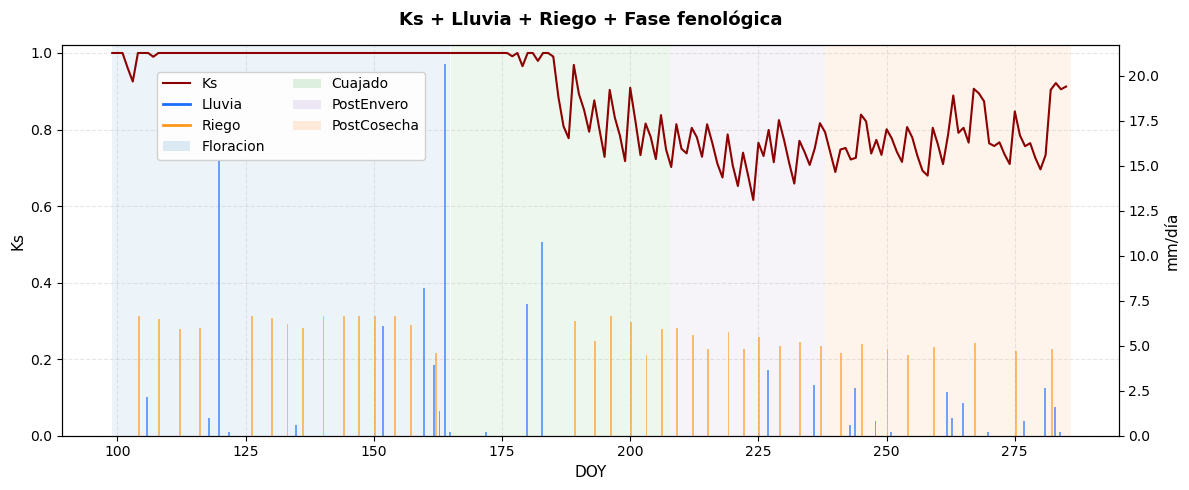

In [14]:
"""
Visualización integrada: Ks + Lluvia + Riego + Fases fenológicas

Gráfico de síntesis que muestra:
  - Evolución del coeficiente de estrés hídrico (Ks)
  - Aportes hídricos: lluvia y riego
  - Fases fenológicas como bandas de fondo coloreadas con paleta fija
  - Eventos extremos de precipitación marcados
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from pathlib import Path

# ---------------------------------------------------------------------
# Carga de resultados de simulación
# ---------------------------------------------------------------------

csv_path = Path("salida_simulacion_2024.csv")
df = pd.read_csv(csv_path)

# Forzar tipos numéricos en columnas clave
for c in ["Ks", "lluvia", "riego_bruto_aplicado_mm"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------------------------------------------------------------------
# Construcción robusta del eje X
# ---------------------------------------------------------------------

def pick_x_axis(df: pd.DataFrame):
    """
    Selecciona el mejor eje X disponible según prioridad: Fecha > J > índice.
    Retorna: (serie_x, es_fecha, valores_numéricos, ancho_base_barras)
    """
    # Prioridad 1: columna Fecha
    if "Fecha" in df.columns:
        d = pd.to_datetime(df["Fecha"], dayfirst=True, errors="coerce")
        if d.notna().mean() > 0.6:
            return d, True, mdates.date2num(d), 1.0
    
    # Prioridad 2: día juliano (J)
    if "J" in df.columns:
        j = pd.to_numeric(df["J"], errors="coerce").fillna(method="ffill").fillna(method="bfill")
        return j, False, j.to_numpy(dtype=float), 0.9
    
    # Fallback: índice secuencial
    idx = pd.RangeIndex(len(df))
    return idx, False, np.asarray(idx, dtype=float), 0.9

x, x_is_date, x_num, base_width = pick_x_axis(df)

# Configuración de barras para lluvia y riego
bar_width = base_width * 0.4
offset = bar_width / 2.0

# ---------------------------------------------------------------------
# Construcción del gráfico
# ---------------------------------------------------------------------

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

# 1) Ks: línea en eje izquierdo
ks_line = None
if "Ks" in df.columns and df["Ks"].notna().any():
    (ks_line,) = ax.plot(x, df["Ks"].clip(0, 1), label="Ks", color='darkred', zorder=3, linewidth=1.5)
    ax.set_ylim(0, 1.02)
    ax.set_ylabel("Ks", fontsize=11)

# 2) Lluvia y Riego: barras en eje derecho
ax2 = ax.twinx()
b_lluvia = b_riego = None

if "lluvia" in df.columns:
    b_lluvia = ax2.bar(
        x_num - offset,
        df["lluvia"].fillna(0).to_numpy(),
        width=bar_width,color='#005eff',  alpha=0.55, label=None, zorder=2
    )

if "riego_bruto_aplicado_mm" in df.columns:
    b_riego = ax2.bar(
        x_num + offset,
        df["riego_bruto_aplicado_mm"].fillna(0).to_numpy(),
        width=bar_width, color='#ff8c00', alpha=0.55, label=None, zorder=2
    )

ax2.set_ylabel("mm/día", fontsize=11)

# 3) Fases fenológicas: bandas coloreadas con paleta fija
phase_patches = []

if "fase" in df.columns and df["fase"].notna().any():
    fases = df["fase"].astype(str).fillna("NA").tolist()
    
    # Detectar segmentos contiguos de la misma fase
    starts = [0]
    for i in range(1, len(fases)):
        if fases[i] != fases[i-1]:
            starts.append(i)
    starts.append(len(fases))
    
    # Paleta de colores fija por fase (personalizable)
    phase_palette = {
        "Floracion":   "#1f77b4",  # Azul
        "Cuajado":     "#2ca02c",  # Verde
        "PostEnvero":  "#9467bd",  # Morado
        "PostCosecha": "#ff7f0e",  # Naranja
    }
    
    # Orden consistente en leyenda: fases conocidas primero, extras después
    phase_order = [f for f in ["Floracion", "Cuajado", "PostEnvero", "PostCosecha"] if f in set(fases)]
    others = [f for f in pd.unique(fases) if f not in phase_order]
    unique_in_order = phase_order + others
    
    # Asignar colores finales (usa paleta fija, fallback a tab20 para extras)
    cmap = plt.get_cmap("tab20")
    color_map = {}
    for i, f in enumerate(unique_in_order):
        color_map[f] = phase_palette.get(f, cmap(i / max(1, len(unique_in_order))))
    
    # Dibujar bandas verticales por fase
    for s in range(len(starts) - 1):
        i0, i1 = starts[s], starts[s + 1]
        fase_lbl = fases[i0]
        x0 = x_num[i0]
        x1 = x_num[i1 - 1] + base_width
        ax.axvspan(x0, x1, color=color_map[fase_lbl], alpha=0.08, linewidth=0, zorder=0.1)
    
    # Preparar patches para leyenda de fases
    phase_patches = [Patch(facecolor=color_map[f], alpha=0.15, label=f) 
                     for f in unique_in_order]

# 4) Manejo de eventos extremos y escala adaptativa
vals = []
if "lluvia" in df.columns:
    vals.append(df["lluvia"].max())
if "riego_bruto_aplicado_mm" in df.columns:
    vals.append(df["riego_bruto_aplicado_mm"].max())
max_precip = pd.Series(vals).max() if vals else 0

if max_precip > 25:
    # Fijar escala para mejor visualización de eventos normales
    ax2.set_ylim(0, 25)
    
    # Identificar eventos extremos
    cond = pd.Series(False, index=df.index)
    if "lluvia" in df.columns:
        cond |= df["lluvia"] > 25
    if "riego_bruto_aplicado_mm" in df.columns:
        cond |= df["riego_bruto_aplicado_mm"] > 25
    
    eventos_extremos = df[cond]
    
    # Estilo de anotaciones para eventos extremos
    arrow_style = dict(
        arrowstyle='-|>', color='red', lw=1.2,
        shrinkA=10, shrinkB=0, mutation_scale=12,
        connectionstyle="arc3,rad=-0.15",  # Curva suave
        zorder=4
    )
    bbox_style = dict(
        boxstyle='round,pad=0.35', facecolor='yellow',
        edgecolor='black', linewidth=0.8, alpha=0.9, zorder=3.5
    )
    
    y_target = min(23, ax2.get_ylim()[1] - 2)
    
    for idx in eventos_extremos.index:
        v_ll = df["lluvia"][idx] if "lluvia" in df.columns else np.nan
        v_rg = df["riego_bruto_aplicado_mm"][idx] if "riego_bruto_aplicado_mm" in df.columns else np.nan
        valor = np.nanmax([v_ll, v_rg])
        
        ax2.annotate(
            f'{valor:.0f}mm',
            xy=(x[idx], y_target),
            xytext=(0, 12),
            textcoords='offset points',
            ha='center', va='bottom',
            bbox=bbox_style,
            arrowprops=arrow_style
        )

# 5) Formateo del eje X si son fechas
if x_is_date:
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlabel("Mes", fontsize=11)
else:
    ax.set_xlabel("DOY" if "J" in df.columns else "Día", fontsize=11)

# 6) Título
ax.set_title("Ks + Lluvia + Riego + Fase fenológica", fontsize=13, fontweight='bold', pad=15)

# 7) Leyenda combinada con líneas proxy para barras
handles = []
labels = []

# Ks usa su línea real
if ks_line is not None:
    handles.append(ks_line)
    labels.append("Ks")

# Líneas proxy para las barras (usando su color real)
if b_lluvia and len(b_lluvia.patches) > 0:
    c_ll = b_lluvia.patches[0].get_facecolor()
    handles.append(Line2D([0], [0], color=c_ll, lw=2, alpha=0.9))
    labels.append("Lluvia")

if b_riego and len(b_riego.patches) > 0:
    c_rg = b_riego.patches[0].get_facecolor()
    handles.append(Line2D([0], [0], color=c_rg, lw=2, alpha=0.9))
    labels.append("Riego")

# Patches de fases fenológicas
if phase_patches:
    handles.extend(phase_patches)
    labels.extend([p.get_label() for p in phase_patches])

# Leyenda posicionada en esquina superior derecha, 2 columnas
if handles:
    ax.legend(handles, labels, bbox_to_anchor=(0.35, 0.95), loc="upper right",
              ncol=2, framealpha=0.9, title=None, fontsize=10)

ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
plt.tight_layout()

# Guardar figura de alta calidad
plt.savefig("grafico_ks_lluvia_riego_Caso_C.png", dpi=300, bbox_inches="tight")

plt.show()